# Energy Analysis
We will be using the new energy layer to analyze the following future PV options
- modules..

We will use a literture-sourced global scale deployment schedule through 2050, then assume that capacity increases at a lower constant rate through 2100.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'EnergyAnalysis')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
altBaselinesfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'Energy_CellModuleTechCompare')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
from platform import python_version 
print(python_version())

3.8.8


Graphing settings

In [3]:
#https://www.learnui.design/tools/data-color-picker.html#palette
#color pallette - modify here for all graphs below
colorpalette=['#000000', #PV ICE baseline
              '#0079C1','#7030A0','#F6A01A', #extreme cases (3) long life, high eff, circular
                '#41B8FF','#EF5675','#FFC425', #hypothetical modules (3) 50 yr, recycleSi, perovskite
                '#467126','#5E9732','#9CD174','#DEF0D1'] #realistic cases (4) greens, perc, shj, topcon, irena

colormats = ['#00bfbf','#ff7f0e','#1f77be','#2ca02c','#d62728','#9467BD','#8C564B'] #colors for material plots       

import matplotlib as mpl #import matplotlib
from cycler import cycler #import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorpalette) #reset the default color palette of mpl

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 6)

scennames_labels = ['PV_ICE','Ideal\nLong-Lived','Ideal\nHigh Eff','Ideal\nCircular',
                    'Hypothetical\n50-year PERC','Hypothetical\nRecycled Si','Hypothetical\nCircular Perovskite',
                    'PERC','SHJ','TOPCon','IRENA\nreg. loss'] 
#,'Lightweight'

Scenarios and materials

In [4]:
#creating scenarios for identical power of multiple technologies, moved to below due to reordering
scennames_ex = ['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite'] #extreme boundaries
scennames_r = ['PV_ICE','r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA'] #realistic cases
scennames_hyp = ['PV_ICE', 'h_50PERC','h_RecycledPERC', 'h_Perovskite'] #hypothetical modules

MATERIALS = ['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet']
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

We will be deploying based on power (not area) because each of these have different efficiencies, and those differences should be accounted for in the simulation. Additionally, we will run the installation compensation to simulate the required replacements for each module type.

In [5]:
#load in a baseline and materials for modification
import PV_ICE

sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames_ex:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis


In [6]:
PV_ICE.__version__

'v0.2.0+418.gd2758f7.dirty'

## Module Types Creation
Starting modifications in 2022, using PV ICE baseline as historical for all modules

**NOTE: Currently have to modify all scenarios before extending the years to avoid errors.**

**NOTE: all dynamic values changed with PV ICE modify functions must feed in a Pandas Series**

In [7]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite'])

In [8]:
celltech_modeff = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-modeffimprovements.csv'),index_col=0) #pull in module eff
celltech_aguse = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-Agusageimprovements.csv'),index_col=0) #pull in Ag use

In [9]:
celltech_modeff.loc[2020]

PERC      22.8
SHJ       23.5
TOPCon    23.2
Name: 2020, dtype: float64

In [10]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2 for all modules with a glass-glass package')

The mass per module area of glass is 12500.0 g/m^2 for all modules with a glass-glass package


In [11]:
timeshift = 2022-1995

## Extreme modules

### PERC_50
This module represents current PERC technology (so good efficiency) if it were to have it's lifetime extended significantly. Glass-glass technology is assumed, expected decreases in silver usage and increases in module efficiency are derived from Zhang et al 2021, Gervais et al 2021 and ITRPV 2022. It is assumed that this module is no more recyclable than current technology (downcycle glass and recycle aluminium frames).

In [12]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_PERC_50', 'mod_eff', 24.5, start_year=2022) #PERC 2030 module eff

In [13]:
#silver modify for PERC
sim1.scenario['ex_PERC_50'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)
#old way
#sim1.scenario['PERC_50'].material['silver'].matdataIn_m.loc[timeshift:,'mat_massperm2'] = celltech_aguse.loc[2022:,'PERC'].values

In [14]:
#modify package to glass glass
sim1.scenario['ex_PERC_50'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022) #

In [15]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_PERC_50', 'mod_degradation', 0.445, start_year=2022) #annual power degradation to reach 80% at 50 yrs
#T50
sim1.modifyScenario('ex_PERC_50', 'mod_reliability_t50', 56.07, start_year=2022)
#t90
sim1.modifyScenario('ex_PERC_50', 'mod_reliability_t90', 59.15, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_PERC_50', 'mod_lifetime', 50, start_year=2022) #project lifetime of 50 years


In [16]:
#Merchant Tail set high
sim1.modifyScenario('ex_PERC_50', 'mod_MerchantTail', 100, start_year=2022) #all installations stay for merchant tail
#Change recycling?

### High Efficiency
This represents a 25 year lifetime module where efficiency has been prioritized. This could represent a silicon based tandem, along the lines of SHJ 

In [17]:
#idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
#df_higheff = pd.DataFrame(index=idx_temp, columns=['mod_eff_p'], dtype=float)
#df_higheff.loc[2022] = 22.0
#df_higheff.loc[2030] = 25.0
#df_higheff.loc[2050] = 30.0
#df_higheff.interpolate(inplace=True)
#module efficiency modify for PERC
sim1.modifyScenario('ex_High_eff', 'mod_eff', 30.0, start_year=2022) #changing module eff

In [18]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_High_eff', 'mod_degradation', 0.7, start_year=2022) #standard current degrdation
#T50
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t50', 29, start_year=2022)
#t90
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t90', 32, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_High_eff', 'mod_lifetime', 25, start_year=2022) #project lifetime of 25 years

### Idealized Perovskite
This perovskite module uses current best module and cell efficiencies, has a prospective life of 15 years and 1.5% degradation rate, and is highly circular. This is a best case scenario for perovskites given current data.

In [19]:
#2022 module eff = 17.9% #https://www.nrel.gov/pv/assets/pdfs/champion-module-efficiencies-rev220401b.pdf
#2050 module eff = 27.3% # Sofia et al 2019 4T future
idx_perovskite_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_perovskite_eff = pd.DataFrame(index=idx_perovskite_eff, columns=['mod_eff_p'], dtype=float)
df_perovskite_eff.loc[2022] = 17.9
df_perovskite_eff.loc[2030] = 27.3
df_perovskite_eff.loc[2050] = 27.3
df_perovskite_eff.interpolate(inplace=True)

In [20]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_Perovskite', 'mod_eff', 27.3, start_year=2022) #changing module eff

In [21]:
#modify package to glass glass
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

In [22]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_Perovskite', 'mod_degradation', 1.47, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('ex_Perovskite', 'mod_lifetime', 15, start_year=2022) #project lifetime of 15 years
#T50
sim1.modifyScenario('ex_Perovskite', 'mod_reliability_t50', 19, start_year=2022)
#t90
sim1.modifyScenario('ex_Perovskite', 'mod_reliability_t90', 22, start_year=2022) 

In [23]:
#As Circular as possible
#100% collection rate
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_collection_eff', 100.0, start_year=2022) #100% collection
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) #100% collection
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) #100% collection

# remanufacturing
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg3_reMFG', 100.0, start_year=2022) #all modules attempt remfg
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_sp_reMFG_recycle', 100.0, start_year=2022) # recycle if can't remfg
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb3_reMFG', 100.0, start_year=2022) # remfg bad mods too
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_reMFG_yield', 98.0, start_year=2022) # REMFG YIELD 98%

#set all other paths to 0
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg0_resell', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg2_stored', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb2_stored', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_Repair', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Perovskite', 'mod_MerchantTail', 0.0, start_year=2022) #


#Material Remanufacture
#Glass
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #99% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send all to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send none to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_ReMFG_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild


#silicon ReMFG 
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_ReMFG_yield', 98.0, start_year=2022) #98% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 0.0, start_year=2022) #send to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


#aluminium_frames recycle
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_ReMFG_yield', 0.0, start_year=2022) #0% yeild


### Lightweighting
- 10% Si
- 50% encapsulant
- 2mm glass
- frameless
- possibly reduced reliability

Could represent a thin film. This does work, it looks very good on Energy basis, however, we need a more realistic existing module to include this further, with more realistic energy demands (e.g.; CdTe).

In [24]:
#module efficiency modify for PERC
#sim1.modifyScenario('ex_Lightweight', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff

In [25]:
#2mm glass calculation
#lightweightglass = (2.0/1000)* 1 * density_glass

#50% encapsulant
#light_encap = pd.Series(sim1.scenario['PV_ICE'].material['encapsulant'].matdataIn_m.loc[timeshift:,'mat_massperm2']*0.5)

#10% silicon
#light_Si = pd.Series(sim1.scenario['PV_ICE'].material['silicon'].matdataIn_m.loc[timeshift:,'mat_massperm2']*0.1)

#modify BOM
#sim1.scenario['ex_Lightweight'].modifyMaterials('glass', 'mat_massperm2', lightweightglass, start_year=2022) #glass
#sim1.scenario['ex_Lightweight'].modifyMaterials('aluminium_frames', 'mat_massperm2', 0.0, start_year=2022) #frameless
#sim1.scenario['ex_Lightweight'].modifyMaterials('encapsulant', 'mat_massperm2', light_encap, start_year=2022) #50% encapsulant
#sim1.scenario['ex_Lightweight'].modifyMaterials('silicon', 'mat_massperm2', light_Si, start_year=2022) #10% silicon


In [26]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
#sim1.modifyScenario('ex_Lightweight', 'mod_degradation', 0.7, start_year=2022) #annual power degradation
#Mod Project Lifetime
#sim1.modifyScenario('ex_Lightweight', 'mod_lifetime', 25, start_year=2022) #project lifetime of 15 years
#T50
#sim1.modifyScenario('ex_Lightweight', 'mod_reliability_t50', 29, start_year=2022) #this will get changed with IRENA alpha/b
#t90
#sim1.modifyScenario('ex_Lightweight', 'mod_reliability_t90', 32, start_year=2022) #this will get changed with IRENA alpha/b

In [27]:
#len(sim1.scenario['ex_Lightweight'].material['silicon'].matdataIn_m)

## Hypothetical Modules

These are modules which have a basis in laboratory or field but have not yet been fully/completely demonstrated or commercialized. These are:
- 50 year PERC module; this is the closest to an existing module, but we don't yet have 50 years worth of data to assert that this exists yet.
- Recycled Silicon PERC; this was a demonstration from Fraunhofer to recycle a silicon cell by skipping the mg-Si step, which has energy and carbon implications
- Circular Perovskite Tandem; cells have been demonstrated in the lab to deposit a perovskite on top of a silicon cell which is removable and remanufacturable, i.e. the silicon wafer doesn't get melted or reprocessed beyond cleaning and a new module is made.

### 50-year PERC gradual improvement

In [28]:
#modified module
moduleinput_m_r_50PERC = os.path.join(altBaselinesfolder, 'mod_r_50PERC.csv')
sim1.createScenario(name='h_50PERC', massmodulefile=moduleinput_m_r_50PERC, energymodulefile=moduleFile_e) 

#load standard materials
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['h_50PERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [29]:
#glass recycling
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_glass_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_glass_target.loc[2022] = 0
df_glass_target.loc[2030] = 100
df_glass_target.loc[2050] = 100
df_glass_target.interpolate(inplace=True)

df_glass_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_glass_lowrecycle.loc[2022] = 0
df_glass_lowrecycle.loc[2030] = 0
df_glass_lowrecycle.loc[2050] = 50
df_glass_lowrecycle.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 
                                          df_glass_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle

sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 
                                          df_glass_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [30]:
#silicon recycled
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_si_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_si_target.loc[2022] = 0
df_si_target.loc[2030] = 0
df_si_target.loc[2050] = 50
df_si_target.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 
                                          df_si_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle

sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop



In [31]:
#aluminium_frames recycle
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_al_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_al_target.loc[2022] = 0
df_al_target.loc[2030] = 100
df_al_target.loc[2050] = 100
df_al_target.interpolate(inplace=True)

df_al_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_al_lowrecycle.loc[2022] = 0
df_al_lowrecycle.loc[2030] = 100
df_al_lowrecycle.loc[2050] = 100
df_al_lowrecycle.interpolate(inplace=True)

df_al_lowCL = pd.DataFrame(index=idx_temp, columns=['mat_EOL_RecycledHQ_Reused4MFG'], dtype=float)
df_al_lowCL.loc[2022] = 0
df_al_lowCL.loc[2030] = 20
df_al_lowCL.loc[2050] = 50
df_al_lowCL.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 
                                          df_al_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 
                                          df_al_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 
                                          df_al_lowCL.loc[2022:,'mat_EOL_RecycledHQ_Reused4MFG'], start_year=2022) #closed-loop


### Recycled PERC
This module is based on the recent test from Fraunhofer ISE in which an old module was dissassembled, and the silicon wafer cleaned, put into a Cz ingot growth process and made using standard PERC processing, creating a 19% efficient module.
https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html

In [32]:
#modified module
moduleinput_m_r_RecyclePERC = os.path.join(altBaselinesfolder, 'mod_r_PERCrecycleSi.csv')
sim1.createScenario(name='h_RecycledPERC', massmodulefile=moduleinput_m_r_RecyclePERC, energymodulefile=moduleFile_e) 

for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['h_RecycledPERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [33]:
#glass recycling
#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
#sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 0.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_EOL_RecycledHQ_Reused4MFG', 0.0, start_year=2022) #closed-loop

#silicon recycled
#mfg scrap
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

#aluminium_frames recycle
#mfg scrap
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

#silver recycling improvement
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_silver_recycleimprove = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_silver_recycleimprove.loc[2022] = 0
df_silver_recycleimprove.loc[2030] = 40
df_silver_recycleimprove.loc[2050] = 100
df_silver_recycleimprove.interpolate(inplace=True)

#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_PG4_Recycling_target',
                                        df_silver_recycleimprove.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) 
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [34]:
#the cool feature of this module was that the wafer was directly put into the Cz process
#therefore, we need to modify the recycling energy to reflect this
#this energy profile is output by the (baseline development) Energy Silicon Manufacturing journal.
altHQRecycle_e = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_eol_recycleHQ_ALT.csv'), index_col=0)
altHQRecycle_e

E_MFG_kWhpkg  E_mfgFuelFraction
1995    600.817735           0.064489
1996    527.042434           0.072326
1997    485.167804           0.077357
1998    432.693843           0.085473
1999    380.620553           0.095834
2000    269.697933           0.075408
2001    236.759317           0.066235
2002    204.221370           0.054188
2003    172.084094           0.037719
2004    159.669155           0.030097
2005    140.254886           0.022532
2006    130.586287           0.022463
2007    121.318358           0.022639
2008    112.451100           0.023120
2009    103.984511           0.023976
2010     95.918593           0.025298
2011     88.253345           0.027195
2012     88.388767           0.027307
2013     88.924859           0.027745
2014     89.861622           0.028498
2015     91.199054           0.029547
2016     76.337157           0.037576
2017     61.875930           0.049814
2018     62.915373           0.053028
2019     64.355487           0.056410
2020     74.096270           0.053503
2021     77.837724           0.055738
2022     77.837724           0.055738
2023     77.837724           0.055738
2024     77.837724           0.055738
2025     77.837724           0.055738
2026     77.837724           0.055738
2027     77.837724           0.055738
2028     77.837724           0.055738
2029     77.837724           0.055738
2030     77.837724           0.055738
2031     77.837724           0.055738
2032     77.837724           0.055738
2033     77.837724           0.055738
2034     77.837724           0.055738
2035     77.837724           0.055738
2036     77.837724           0.055738
2037     77.837724           0.055738
2038     77.837724           0.055738
2039     77.837724           0.055738
2040     77.837724           0.055738
2041     77.837724           0.055738
2042     77.837724           0.055738
2043     77.837724           0.055738
2044     77.837724           0.055738
2045     77.837724           0.055738
2046     77.837724           0.055738
2047     77.837724           0.055738
2048     77.837724           0.055738
2049     77.837724           0.055738
2050     77.837724           0.055738

In [35]:
#modify silicon recycling energy
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ', altHQRecycle_e.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ_fuelfraction', altHQRecycle_e.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [36]:
sim1.scenario['h_RecycledPERC'].material['silicon'].matdataIn_e.iloc[25:30,]

year  e_mat_extraction  e_mat_MFG  e_mat_MFG_fuelfraction  \
25  2020            0.0062     169.06                    0.22   
26  2021            0.0062     170.73                    0.21   
27  2022            0.0062     169.05                    0.20   
28  2023            0.0062     168.80                    0.20   
29  2024            0.0062     169.09                    0.20   

    e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
25               24.5              600.0            0.09   
26               24.5              600.0            0.09   
27               24.5              600.0            0.09   
28               24.5              600.0            0.09   
29               24.5              600.0            0.09   

    e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
25                          0.0                    0.4                1.6   
26                          0.0                    0.4                1.6   
27                          0.0                    0.4                1.6   
28                          0.0                    0.4                1.6   
29                          0.0                    0.4                1.6   

    e_mat_Recycled_HQ  e_mat_Recycled_HQ_fuelfraction  
25         138.380000                        0.200000  
26         143.040000                        0.190000  
27          77.837724                        0.055738  
28          77.837724                        0.055738  
29          77.837724                        0.055738

### Hopeful Perovskite, Gradually increasing circularity

In [37]:
#modified module
moduleinput_m_r_perovskite = os.path.join(altBaselinesfolder, 'mod_r_perovskite.csv')
sim1.createScenario(name='h_Perovskite', massmodulefile=moduleinput_m_r_perovskite, energymodulefile=moduleFile_e) 

#modified materials
#glass
matinput_glass_m_remfg = os.path.join(altBaselinesfolder,'material_mass_glass_r_perovskite.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['h_Perovskite'].addMaterial('glass', massmatfile=matinput_glass_m_remfg, energymatfile=matbaseline_e_glass)

#silicon
matinput_silicon_m_remfg = os.path.join(altBaselinesfolder,'material_mass_silicon_r_perovskite.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['h_Perovskite'].addMaterial('silicon', massmatfile=matinput_silicon_m_remfg, energymatfile=matbaseline_e_si)

#load standard materials
subMats =['silver', 'aluminium_frames','copper','encapsulant', 'backsheet']
for mat in range (0, len(subMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+subMats[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+subMats[mat]+'.csv')
    sim1.scenario['h_Perovskite'].addMaterial(subMats[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [38]:
#aluminium_frames recycle
#eol
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG',100.0, start_year=2022) #closed-loop


## Commercialized Modules with Expected Continued Improvement

For these more realisitic evolving modules, some module and material input files have been modified and are stored in the baselines\Energy_CellModuleTechCompare folder.

In [39]:
altBaselinesfolder

'C:\\Users\\hmirletz\\Documents\\GitHub\\PV_ICE\\PV_ICE\\baselines\\Energy_CellModuleTechCompare'

Improving recycling:
- 2022: 15% collection, 75% recycled module, 100% downcycled glass, 100% HQ al frames, 20% closed loop
- 2030: 30% collection, 80% recycled module, 30% closed-loop glass, 30% closed-loop silicon, 30% closed-loop silver, 50% closed loop Al frames
- 2050: 75% collection, 95% recycled module, 75% closed loop recycled glass, 75% closed loop recycled silicon, 75% closed-loop silver, 100% closed loop al frames

### PERC

In [40]:
#modified module
moduleinput_m_r_PERC = os.path.join(altBaselinesfolder, 'mod_r_PERC.csv')
sim1.createScenario(name='r_PERC', massmodulefile=moduleinput_m_r_PERC, energymodulefile=moduleFile_e) 

In [41]:
#module efficiency modify for PERC
sim1.modifyScenario('r_PERC', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [42]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_PERC'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_PERC'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_PERC'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_PERC'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_PERC'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [43]:
#modify silver usage for PERC
sim1.scenario['r_PERC'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)

In [44]:
#modify package to glass glass
sim1.scenario['r_PERC'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

### SHJ
This is a modern SHJ module with expected silver and module efficiency improvements taken from Zhang et al 2021, Gervais et al 2021, and ITPRV 2022. See PERC vs SHJ vs TOPCon for a more detailed evaluation.

In [45]:
#modified module
moduleinput_m_r_SHJ = os.path.join(altBaselinesfolder, 'mod_r_SHJ.csv')
sim1.createScenario(name='r_SHJ', massmodulefile=moduleinput_m_r_SHJ, energymodulefile=moduleFile_e) 

In [46]:
#module efficiency modify for SHJ
sim1.modifyScenario('r_SHJ', 'mod_eff', celltech_modeff.loc[2022:,'SHJ'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [47]:
#load modified materials
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_SHJ'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_SHJ'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_SHJ'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_SHJ'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_SHJ'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [48]:
#modify silver usage for SHJ
sim1.scenario['r_SHJ'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'SHJ'], start_year=2022)

In [49]:
#modify package to glass glass
sim1.scenario['r_SHJ'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

Text(0.5, 1.0, 'Silicon Management Evolution')

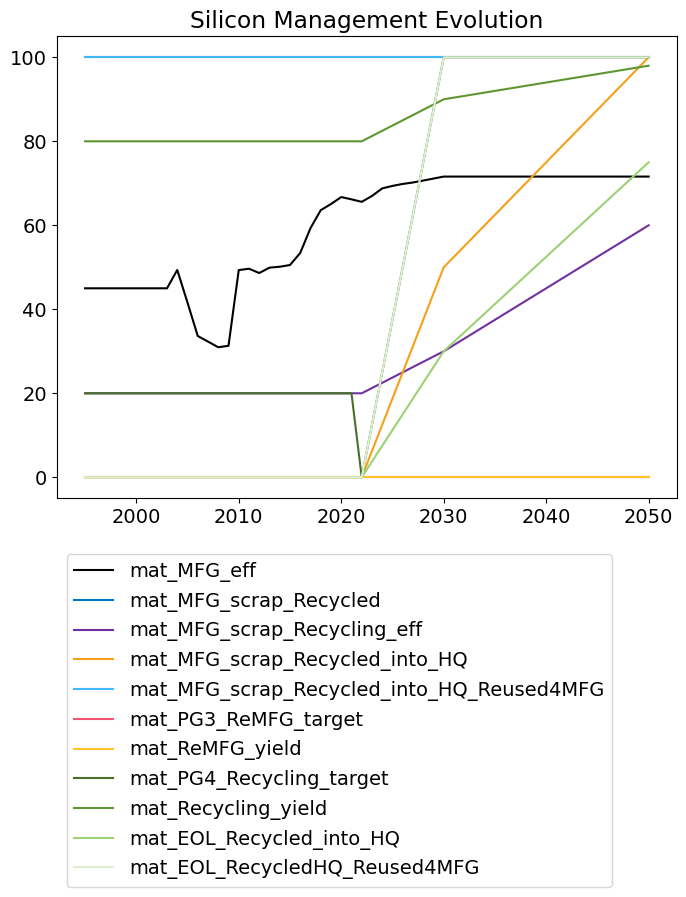

In [50]:
plt.plot(sim1.scenario['r_SHJ'].material['silicon'].matdataIn_m.iloc[:,0],sim1.scenario['r_SHJ'].material['silicon'].matdataIn_m.iloc[:,3:])
plt.legend(sim1.scenario['PV_ICE'].material['silicon'].matdataIn_m.iloc[:,3:].columns, 
           bbox_to_anchor=(0, -0.1), loc='upper left', ncol=1)
plt.title('Silicon Management Evolution')

Text(0.5, 1.0, 'Glass Management Evolution')

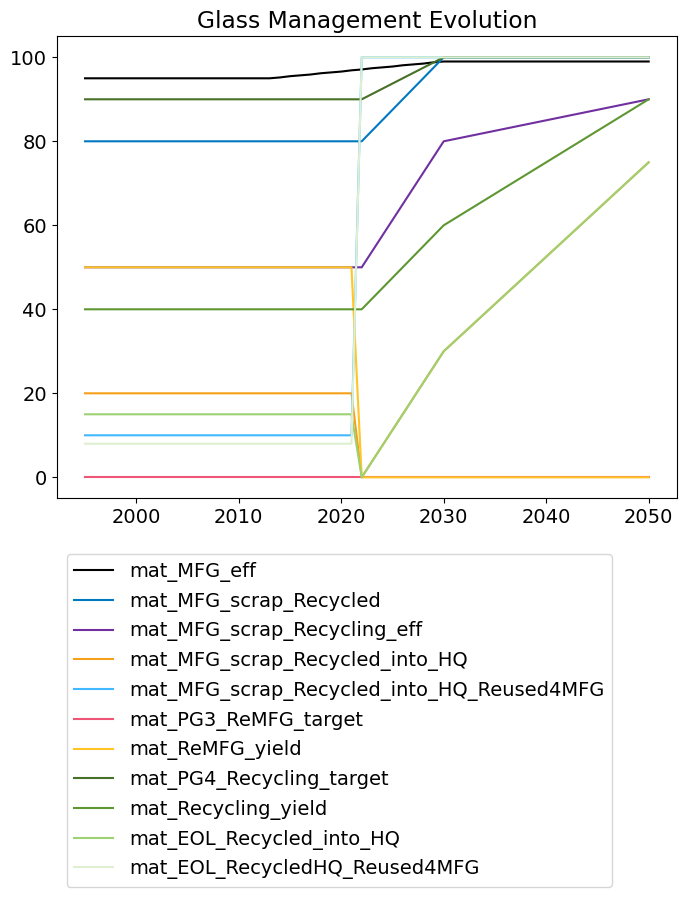

In [51]:
plt.plot(sim1.scenario['r_SHJ'].material['glass'].matdataIn_m.iloc[:,0],sim1.scenario['r_SHJ'].material['glass'].matdataIn_m.iloc[:,3:])
plt.legend(sim1.scenario['PV_ICE'].material['glass'].matdataIn_m.iloc[:,3:].columns, 
           bbox_to_anchor=(0, -0.1), loc='upper left', ncol=1)
plt.title('Glass Management Evolution')

Text(0.5, 1.0, 'Glass Management Evolution')

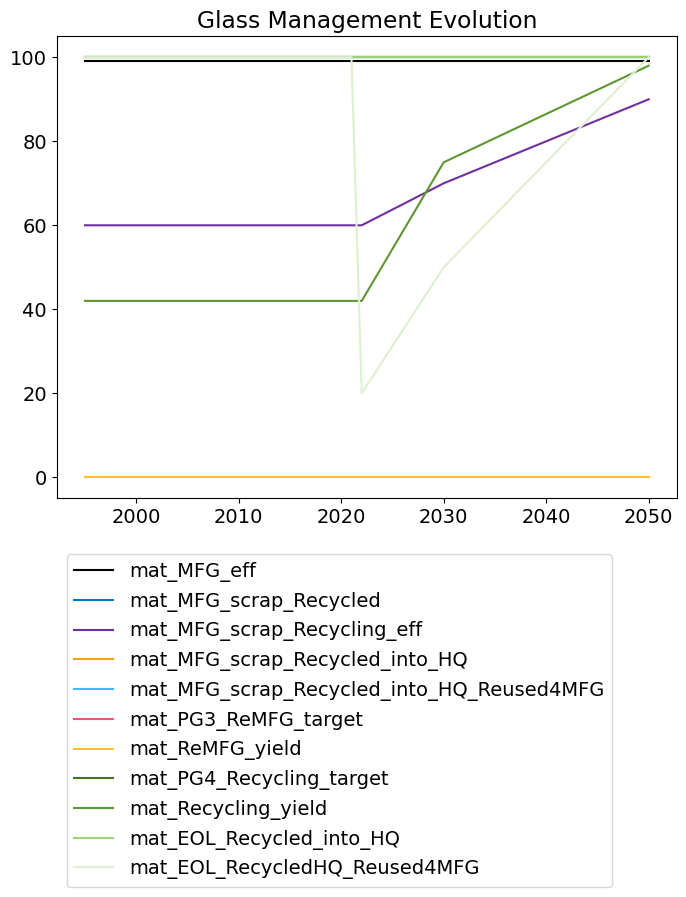

In [52]:
plt.plot(sim1.scenario['r_SHJ'].material['aluminium_frames'].matdataIn_m.iloc[:,0],sim1.scenario['r_SHJ'].material['aluminium_frames'].matdataIn_m.iloc[:,3:])
plt.legend(sim1.scenario['PV_ICE'].material['aluminium_frames'].matdataIn_m.iloc[:,3:].columns, 
           bbox_to_anchor=(0, -0.1), loc='upper left', ncol=1)
plt.title('Glass Management Evolution')

Text(0.5, 1.0, 'Glass Management Evolution')

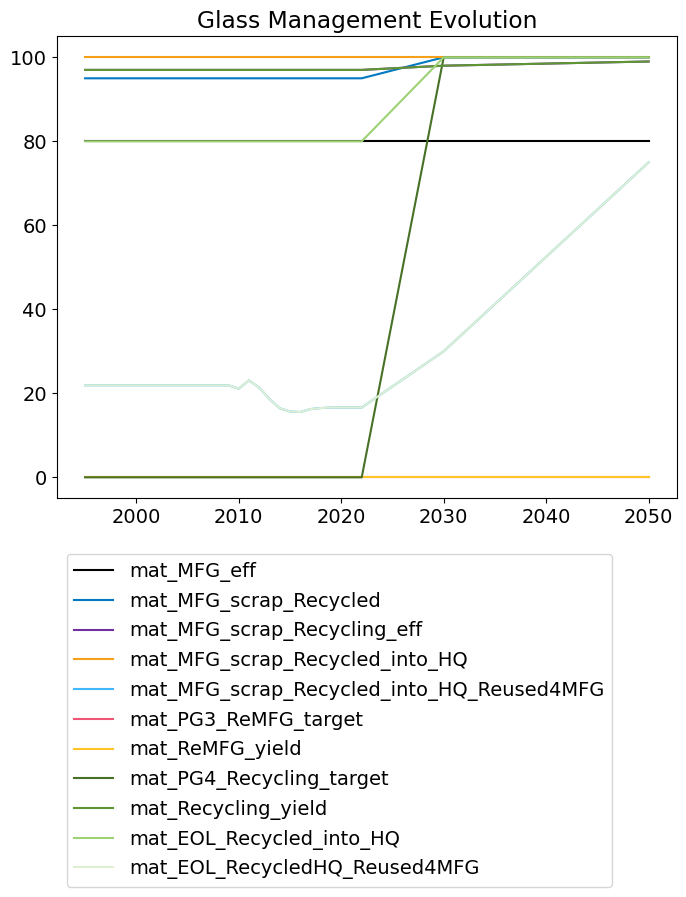

In [53]:
plt.plot(sim1.scenario['r_SHJ'].material['silver'].matdataIn_m.iloc[:,0],sim1.scenario['r_SHJ'].material['silver'].matdataIn_m.iloc[:,3:])
plt.legend(sim1.scenario['PV_ICE'].material['aluminium_frames'].matdataIn_m.iloc[:,3:].columns, 
           bbox_to_anchor=(0, -0.1), loc='upper left', ncol=1)
plt.title('Glass Management Evolution')

### TOPCon

In [54]:
#modified module
moduleinput_m_r_TOPCon = os.path.join(altBaselinesfolder, 'mod_r_TOPCon.csv')
sim1.createScenario(name='r_TOPCon', massmodulefile=moduleinput_m_r_TOPCon, energymodulefile=moduleFile_e) 

In [55]:
#module efficiency modify
sim1.modifyScenario('r_TOPCon', 'mod_eff', celltech_modeff.loc[2022:,'TOPCon'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [56]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_TOPCon'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_TOPCon'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_TOPCon'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_TOPCon'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_TOPCon'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [57]:
#modify silver usage for PERC
sim1.scenario['r_TOPCon'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'TOPCon'], start_year=2022)

In [58]:
#modify package to glass glass
sim1.scenario['r_TOPCon'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

### IRENA Reg. Loss with improved recycling
This scenario uses the IRENA 2016 regular loss scenario results, or a low quality module, and assumes the same EoL recycling improvement as the previous three scenarios

In [59]:
#modified module
moduleinput_m_r_IRENA = os.path.join(altBaselinesfolder, 'mod_r_IRENAregloss.csv')
sim1.createScenario(name='r_IRENA', massmodulefile=moduleinput_m_r_IRENA, energymodulefile=moduleFile_e) 

In [60]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_IRENA'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_IRENA'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_IRENA'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_IRENA'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_IRENA'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [61]:
sim1.modifyScenario('r_IRENA', 'mod_degradation', 0.9, start_year=2022) 

### Modify Years 2000 to 2100
We do this after we modify the baselines to propogate the modified 2050 values forward

In [62]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim1.trim_Years(startYear=2000, endYear=2100)

Trimming and extending  PV_ICE
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Mass, years now encompass  2000  to  2100
Trimming and extending  ex_PERC_50
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PER

In [63]:
#check
#sim1.scenario['h_Perovskite'].dataIn_m

### Apply deployment curve
For the full derivation of the deployment curve, see the "PV Installations - Global" development journal. Essentially, the projection is 2000-2021 IRENA historical installation data, 2022 through 2050 is a quadratic fit to achieve 75 TW in 2050, and from 2050 to 2100 is a linear increase to 86 TW based on 2000-2021 global increase in electricity capacity.

This is the deployment curve applied to all PV technologies - however, it will be modified for each PV tech using the installation compensation method, increasing it for any replacement modules required to maintain capacity.

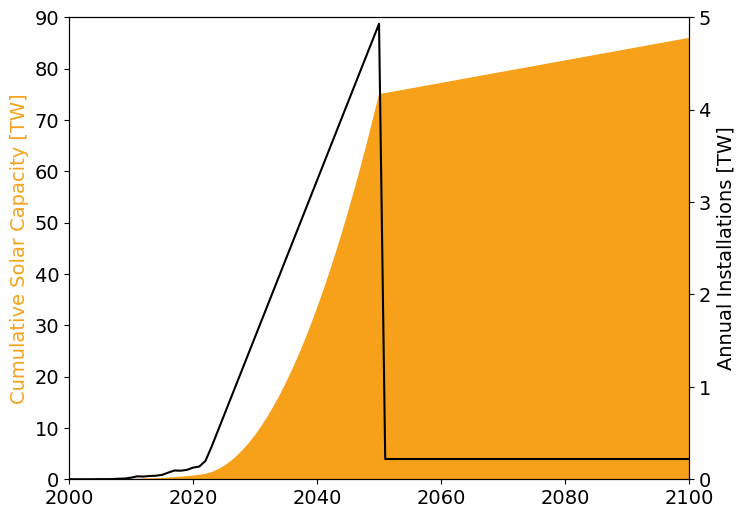

In [64]:
global_projection = pd.read_csv(os.path.join(supportMatfolder,'output-globalInstallsProjection.csv'), index_col=0)

fig, ax1 = plt.subplots()

ax1.stackplot(global_projection.index, global_projection['World_cum']/1e6, color='#F7A11A')
ax1.set_ylabel('Cumulative Solar Capacity [TW]', color='#F7A11A')
ax1.set_ylim(0,90)
ax1.set_xlim(2000,2100)
ax2 = ax1.twinx()
ax2.plot(global_projection['World_annual_[MWdc]']/1e6)
ax2.set_ylabel('Annual Installations [TW]')
ax2.set_ylim(0,5)
plt.show()



In [65]:
#deployment projection for all scenarios
sim1.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', 
                    value= global_projection['World_annual_[MWdc]'], start_year=2000)
#for scen in scennames:
#    sim1.scenario[scen].dataIn_m.loc[0:len(global_projection.index-1),'new_Installed_Capacity_[MW]'] = global_projection['World_annual_[MWdc]'].values

# Calculate Mass flow
Can just calc mass here (exclude energy) because we're going to immediately do Install Compensation.

In [66]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'h_50PERC', 'h_RecycledPERC', 'h_Perovskite', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA'])

In [67]:
scennames_ex = ['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite'] #extreme boundaries
scennames_r = ['PV_ICE','r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA'] #realistic cases
scennames_hyp = ['PV_ICE', 'h_50PERC','h_RecycledPERC', 'h_Perovskite'] #hypothetical modules

scennames_all = ['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite',
                 'h_50PERC','h_RecycledPERC', 'h_Perovskite',
                'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA']

In [68]:
for scen in sim1.scenario.keys():
    print(sim1.scenario[scen].material.keys())

dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])


In [69]:
IRENAregloss = {'alpha':5.692,
                   'beta':29.697}

idx_temp = pd.RangeIndex(start=2022,stop=2101,step=1) #create the index
evolve_weibull = pd.DataFrame(index=idx_temp, columns=['alpha','beta'], dtype=float)
evolve_weibull.loc[2022] = [5.3759,30]
evolve_weibull.loc[2030] = [5.1   ,35]
evolve_weibull.loc[2050] = [4.602 ,40.767]

evolve_weibull.interpolate(inplace=True)
evolve_weibull = round(evolve_weibull,3)
#evolve_weibull_temp = evolve_weibull.reset_index(drop=True)
#evolve_weibull_temp.to_dict(orient='dict')
#dict([(i,[a,b,c ]) for i, a,b,c in zip(df.ID, df.A,df.B,df.C)])
dict_weibull = {'alpha':evolve_weibull['alpha'].tolist(),
                'beta':evolve_weibull['beta'].tolist()}
evolve_weibull.to_csv(os.path.join(altBaselinesfolder,'evolve_weibull.csv'))

In [70]:
bifiFactors = {'PV_ICE':0.0,
               'ex_PERC_50':0.7, # ITRPV 2022, Fig. 58
               'ex_High_eff': 0.9,
               'ex_Perovskite': 0.0,
               'h_50PERC':0.7,
               'h_RecycledPERC': 0.6,
               'h_Perovskite': 0.0,
               'r_PERC':0.7,
               'r_SHJ':0.9, # ITRPV 2022, Fig. 58
               'r_TOPCon':0.8, # ITRPV 2022, Fig. 58              
                'r_IRENA':0.0 } 

#MAY NEED TO CHANGE TO BE DYNAMIC
#               'ex_Lightweight':0.0,

In [71]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = pd.RangeIndex(start=2000,stop=2101,step=1) #create the index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifiPathDict={}

for f in bifiFactors.keys(): #loop over module types
    bifi = df_temp.copy() #copy of df
    bifi['bifi'] = bifiFactors[f] #assign column
    bifipath = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi.to_csv(path_or_buf=bifipath, index_label='year') #create file
    bifiPathDict[str(f)] = bifipath
    #append bifi path to dict? or list?


In [72]:
for scen in sim1.scenario.keys(): #loop over scenarios
    if scen in ['r_IRENA']: #,'ex_Lightweight'
        sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
    else:
        sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on 

Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


In [73]:
#sim1.calculateMassFlow()

In [74]:
#sim1.calculateMassFlow(scenarios=['ex_Lightweight','r_IRENA'], weibullInputParams=IRENAregloss)
#need to create an upgrade to weibull params to account for evolving params
#dict_weibull # evolve_weibull
#sim1.calculateMassFlow(scenarios=['r_IRENA'])

In [75]:
ii_yearly, ii_cumu = sim1.aggregateResults() #have to do this to get auto plots

In [76]:
#sim1.scenario['r_IRENA'].dataOut_m['WeibullParams']

(0.0, 90.26425956655)

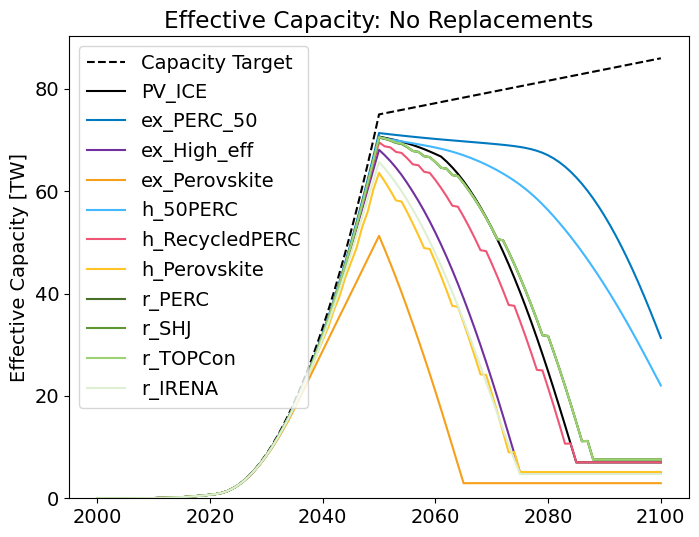

In [77]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity')
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())
plt.legend()
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)

(0.0, 90.26425956655)

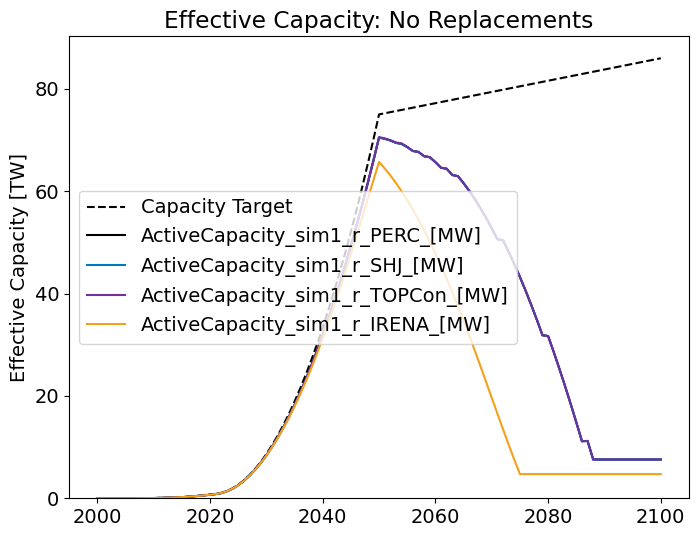

In [78]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity').filter(like='r_')
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
plt.plot(effective_capacity/1e6, label=effective_capacity.columns)
plt.legend()
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)

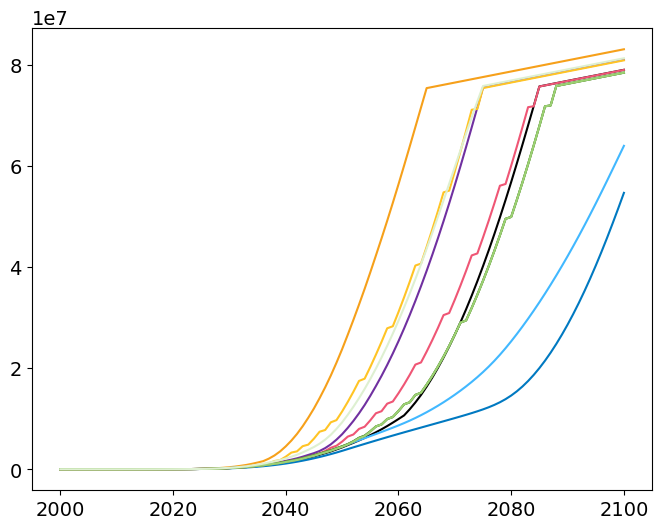

In [79]:
plt.plot(ii_yearly.filter(like='Decommisioned'))

(0.0, 90.26425956655)

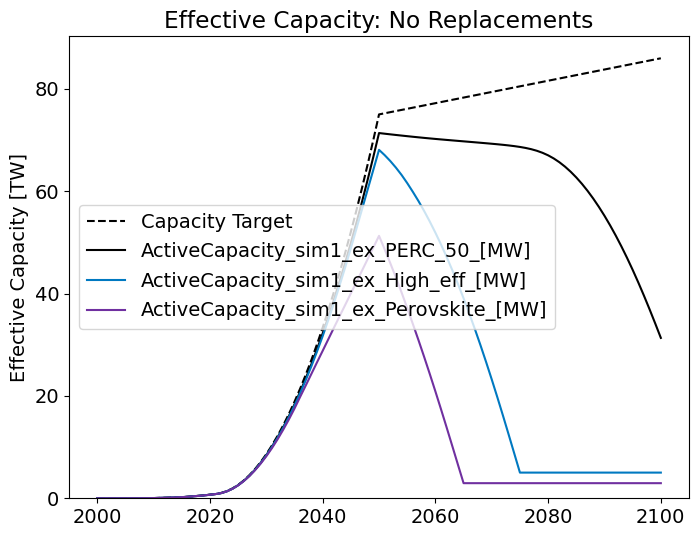

In [80]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity').filter(like='ex_')
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
plt.plot(effective_capacity/1e6, label=effective_capacity.columns)
plt.legend()
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)

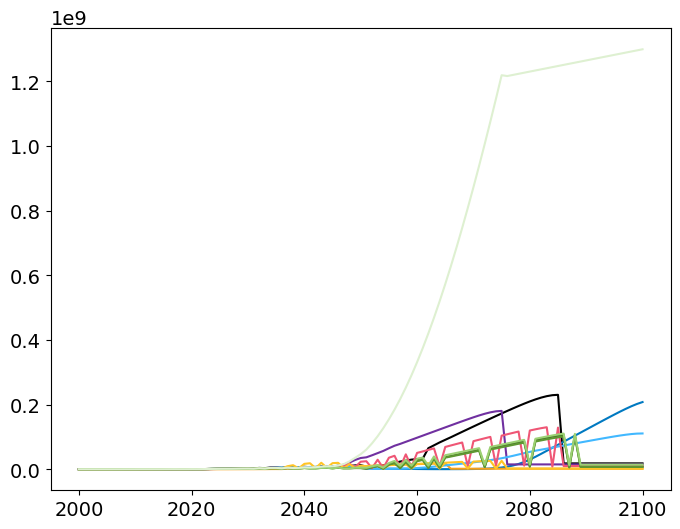

In [81]:
plt.plot(ii_yearly.filter(like='WasteAll_Module'))

array(['Yearly_Sum_Area_disposed', 'Yearly_Sum_Area_disposedby_Failure',
       'Yearly_Sum_Area_disposedby_ProjectLifetime',
       'Yearly_Sum_Power_disposed', 'Yearly_Sum_Power_disposedby_Failure',
       'Yearly_Sum_Power_disposedby_ProjectLifetime'], dtype=object)

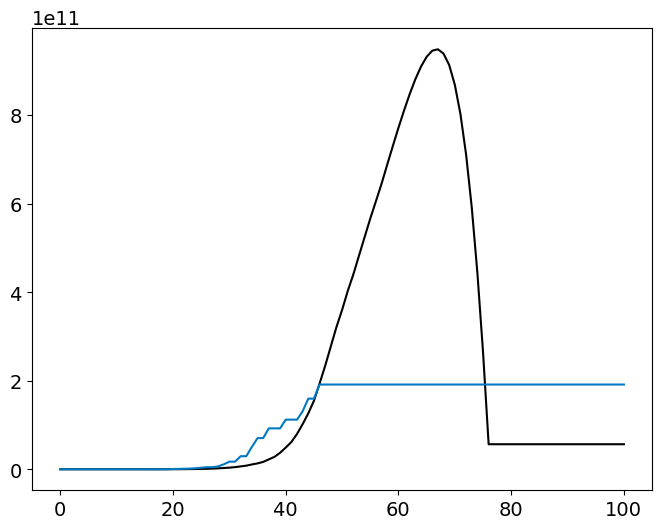

In [82]:
plt.plot(sim1.scenario['r_IRENA'].dataOut_m['Yearly_Sum_Power_disposedby_Failure'])
plt.plot(sim1.scenario['r_IRENA'].dataOut_m['Yearly_Sum_Power_disposedby_ProjectLifetime'])
#plt.plot(sim1.scenario['r_PERC'].dataOut_m['Yearly_Sum_Power_disposedby_Failure'])


sim1.scenario['r_IRENA'].dataOut_m.filter(like='disposed').columns.values

In [83]:
diagnose = ii_yearly.filter(like='r_IRENA').filter(like='WasteEOL')
diagnose.columns.values

array(['WasteEOL_glass_sim1_r_IRENA_[Tonnes]',
       'WasteEOL_silicon_sim1_r_IRENA_[Tonnes]',
       'WasteEOL_silver_sim1_r_IRENA_[Tonnes]',
       'WasteEOL_aluminium_frames_sim1_r_IRENA_[Tonnes]',
       'WasteEOL_copper_sim1_r_IRENA_[Tonnes]',
       'WasteEOL_encapsulant_sim1_r_IRENA_[Tonnes]',
       'WasteEOL_backsheet_sim1_r_IRENA_[Tonnes]',
       'WasteEOL_Module_sim1_r_IRENA_[Tonnes]'], dtype=object)

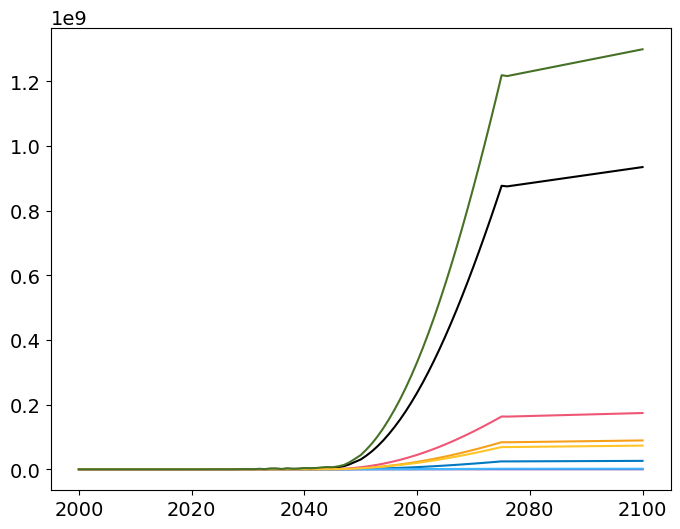

In [84]:
plt.plot(diagnose)

# Installation Compensation
Make the installations always match up to the cumulative capacity deployment schedule. 

In [85]:
#currently takes ~40 mins to run with 7 materials and 12 scenarios

for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
    print(row)
    for scen in sim1.scenario.keys(): #loop over scenarios
        print(scen)
        Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
        sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
        #calculate flows for that scenario with it's bifi factor and modified weibull
        if scen in ['r_IRENA']: #,'ex_Lightweight'
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
        else:
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


0
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2532456700.9151797  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11518546.694268066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71994785.19846186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  252931173.78063294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218339.404914325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022394.237767588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27706932.65677402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97711618.73318519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  574677.8975037739  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334496785.83409405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2390139947.8364835  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56308260.0495583  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2134093.931282162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285947528.2536086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376994924.2570825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41432216.863991305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263380.9404062508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213221599.14535347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1312550819.218989  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39557723.941515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422341.10021999583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203453885.5583714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1599376521.6742687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53220676.44524092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  537615.7500202699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266122819.51848605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42584101349.58458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537469091.993155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893380.068700368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055460638.342605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2534092276.158384  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11519339.781365592  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72075260.91208686  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  253203331.70350188  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707234.70119778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97789088.61538108  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  575491.115601273  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334753538.59151816  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2391775523.079703  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56367385.06365011  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2135759.0847402574  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  286219686.1764777  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1377699148.656428  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41469947.04967784  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  263807.13746591605  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213388327.6672611  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1313242122.0697224  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39594761.83021643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  422759.4771501257  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203617554.84134457  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1601762765.2592418  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53356861.953731745  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539059.9061734854  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266724619.06234533  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42585009842.87568  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537517766.280215  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8893896.22693145  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055675728.509505  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2535481921.6816435  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11520013.617643794  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72140184.8710994  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  253424685.07003537  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707234.70119778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97851587.61327524  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  576135.6729130452  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  334962362.5222097  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2393165168.602963  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56415084.298843  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2137102.4509558957  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  286441039.54301053  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1378291989.8878362  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41500106.46577937  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264141.83983147953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213522687.32165253  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1313824085.480372  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39624367.86253629  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  423088.03818788106  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203749449.18097675  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1604788835.747661  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53520846.082552716  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  540768.3449546956  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  267455165.39652935  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42585881701.01461  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537562120.0312712  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8894358.318409087  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055873323.669926  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2538842403.082632  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11521643.108217014  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72288278.12211075  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  253938021.36887687  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707234.70119778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97994149.4644606  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  577431.3763899197  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  335446642.0494195  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2396525650.003937  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56523887.50366748  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2140166.7044795267  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  286954375.8418524  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1379830737.0040128  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41573945.25883479  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264831.5713619421  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213857125.70044124  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1315334598.7045066  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39696851.81535215  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  423765.114093931  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204077751.07575077  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1608931095.63317  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53719888.77590053  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  542595.8460951895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  268356690.3662424  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42586311566.00323  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537582747.6650143  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8894547.710059477  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7055966752.504578  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707234.70119778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98147292.95305963  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  578746.9807390944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  335947552.31874543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1381572778.264172  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41653408.33062786  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  265532.33300559426  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214203675.36709705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1317044675.9048493  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39774856.84913069  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424453.01772577304  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204423213.78231475  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1613358960.7146666  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53922044.348956995  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  544350.2177500332  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269238319.3402361  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42586785216.046104  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537604353.1735764  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8894735.209672948  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7056060977.175499  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707234.70119778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98147292.95305963  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  578746.9807390944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  335947552.31874543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1381572778.264172  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41653408.33062786  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  265578.1496257628  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214203675.36709705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1317044675.9048493  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39774856.84913069  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424549.0581089627  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204445710.32902023  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1613358960.7146666  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53926975.05527435  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  544420.4924893733  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269259716.6830606  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42592570926.768906  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1537855845.825021  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8896780.476248227  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7057152357.220148  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707234.70119778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98147292.95305963  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  578746.9807390944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  335947552.31874543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1381572778.264172  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41653408.33062786  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  265633.5430268905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214232284.58577955  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1317044675.9048493  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39774856.84913069  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424663.0784184279  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204473674.19062555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1613358960.7146666  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53933110.817985676  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  544506.0357223136  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269286537.2362636  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42600150790.493095  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1538171471.8450603  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8899245.46179184  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7058532016.907296  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707234.70119778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98147292.95305963  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  578746.9807390944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  335947552.31874543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1381833267.225563  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41661705.53940969  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  265703.9251881374  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214270968.34056818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1317292572.4976418  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39782752.96025847  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424805.03560185246  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204510487.92337382  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1613603359.2123785  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53941302.85594396  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  544617.5718410672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269322831.4865293  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42611022048.88658  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1538605297.4108875  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8902473.023879725  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7060454050.684239  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707234.70249647  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98171768.43077907  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  578919.9509062744  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  336029223.6891893  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1382190785.6467898  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41672912.03822069  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  265793.31649019767  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214321997.2468395  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1317632743.2905562  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39793415.693589106  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424981.25823776616  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204559040.78800187  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1613942776.673635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53952191.52038908  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  544760.6783196675  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269371276.82749355  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42626173271.22289  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1539202514.805869  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8906736.674361635  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7063111162.626244  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707239.232230313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98203818.01534323  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  579137.3455870838  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  336137065.06858796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1382667525.0269835  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41687613.741635226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  265904.97241295857  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214388626.82204807  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1318086265.1095464  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39807401.41314958  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425195.74291566096  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204622425.45350793  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1614391747.697243  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53966177.811494194  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  544937.6703191354  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269434025.4692605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42646621558.53739  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1539998587.2471611  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8912191.59225072  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7066682693.067287  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.8032485987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27707627.828486342  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98243197.16813952  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  579393.4406372607  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  336270558.4002219  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1383266532.1106966  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41705802.3757364  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  266036.9488967267  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214471187.52621764  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1318655994.7909634  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39824701.04948716  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425441.8614382137  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204700950.8749312  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1614941233.013645  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53982933.62745209  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  545141.0322975627  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269509760.6247978  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42672400079.22243  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1540976209.857027  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8918614.25579827  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7071101481.182468  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.803248624  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27711968.805646077  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98293342.72212802  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  579704.6603310691  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  336441848.8442035  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1384048428.114588  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41729174.22356  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  266199.028312772  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214577815.18064588  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1319399538.9290345  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39846926.51215564  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425733.94625689264  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204802348.4610702  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1615685942.0176516  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54005231.73618826  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  545399.7465139427  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269611317.064444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42707109881.48274  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1542258566.3808835  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8926654.190878576  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7076941956.913429  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022447.812463706  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27728070.72936343  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98356103.769985  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  580075.0094103678  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  336657910.9571565  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1385052599.356734  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41758714.79034598  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  266394.4501945306  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214713498.86120674  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1320354284.2382987  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39875013.07387758  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  426072.29704936495  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204931353.70651263  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1616667622.210792  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54034129.39738701  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  545719.0957819825  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269743961.75306743  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42752488027.192894  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1543891865.2561352  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8936390.533880638  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7084439048.780024  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022457.8940019803  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27761402.099854477  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98433296.58487934  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  580502.272802926  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  336923308.1721132  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2400323231.746793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56640766.61416633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2143458.4018772515  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287485340.7273389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1386308749.0554786  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41795413.17364721  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  266623.16012569907  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214881769.14413893  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1321548393.9802065  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39909898.96132878  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  426449.91115170455  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205091313.29120523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1617867519.8537116  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54069192.63437042  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  546083.2091085968  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269904696.66871125  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42807483048.63417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1545866464.9431117  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8947431.49776285  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7093490897.423284  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3022676.6955859363  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27809378.014577296  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98515866.05291414  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  580962.4920183346  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  337206813.54892486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2402331190.915968  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56689292.25905444  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2144825.042488386  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287716749.9335379  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1387669374.0561478  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41834887.75436774  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  266867.1669911389  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  215062505.45711458  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1322841819.0950685  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39947423.932630554  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  426854.9556394885  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205263123.2213882  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1619134022.6342595  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54105940.53806197  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  546463.8448885464  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270072930.4163029  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42867449513.50647  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1548014305.4616904  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8959525.12034429  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7103323819.124145  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3024229.7869898467  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27875082.726052765  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98629089.50503607  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  581593.5680024918  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  337595570.53406394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2405189134.4135103  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56758359.17704808  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2146770.1924237167  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  288046116.409849  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1389545622.5771835  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41889321.65324434  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267198.529306804  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  215311718.701063  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1324625401.6087193  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39999169.39656969  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  427408.0510542021  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205500028.076525  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1620946796.465477  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54158535.46167488  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  547003.414097009  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270313712.6165059  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42947226482.18976  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1550871705.9463131  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8975613.988547567  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7116405141.964584  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56893339  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3029272.04541417  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27954948.72676464  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98742169.33400145  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  582223.8434711801  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  337983834.3836883  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2408131220.1390467  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56829459.53075017  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2148772.6105483896  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  288385179.939012  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1391429991.2230349  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41943991.13394717  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267526.20128853485  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  215562003.5479542  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1326416703.2024746  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40051138.80718813  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  427958.09014451754  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205737951.60922447  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1622700788.5855496  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54209423.507701665  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  547520.4311802131  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270546680.6454462  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43029251197.13794  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1553809614.7702813  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8992156.1666974  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7129855036.02351  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.56896807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3040376.059533389  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28053718.22614601  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98898020.37547421  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  583092.513764623  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  338518954.8015721  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2412274910.2456603  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56929598.63603014  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2151592.8547379067  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  288862723.5330385  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1394041576.2290325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42019758.684210524  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267973.2338624193  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  215908874.16539186  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1328899304.679511  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40123164.27515615  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  428712.859348143  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  206067690.6394355  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1625282818.788107  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54284334.25248265  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  548274.0951047875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270889625.79505724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43138306602.47676  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1557715691.589308  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9014149.707844809  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7147737251.759179  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2542639984.8254743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11523484.547853967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72447363.5780674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254468986.25436357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218611.90453048  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3058363.6566317766  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28168377.73839603  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99068444.83840983  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  584042.4122499274  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  339104113.61066264  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2416940600.6889663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  57042352.74033928  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2154768.3784919176  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  289400425.5632541  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1396913137.237622  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42103068.68275658  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  268456.969921277  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  216290272.7974682  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1331629042.2086177  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40202359.67755252  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  429534.4778297807  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  206430252.38073725  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1627969503.2185645  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54362280.85533492  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  549050.5803150196  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  271246469.25529784  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43258413433.83266  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1562017601.3232489  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9038372.0242839  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7167431610.447414  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2554989721.6656146  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11529472.910044206  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72776407.00249925  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  255621826.03453988  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10218715.17299107  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3082833.978686269  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28297489.584421642  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99233446.8121281  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  584962.0872907483  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  339670654.0988966  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2421676844.902395  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  57156811.89286207  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2157991.9219711307  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  289946258.63128626  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1399708447.1253006  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42184166.47659822  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  268920.27211236884  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  216661543.02941388  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1334286294.5821714  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40279452.133786306  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  430326.21581747226  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  206783185.95329615  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1630551638.663388  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54437194.105211094  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  549789.4265498094  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  271589425.87336034  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43378428601.087  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1566316227.8909779  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9062575.854539914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7187110938.635935  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2577350548.8734255  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11540315.62952293  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  73372183.5160256  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  257709194.490767  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10222448.128349004  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3114412.16814802  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28447442.97735922  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99452710.43102492  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  586184.2016274158  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  340423503.98852205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2434129361.793114  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  57457747.5004573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2166467.2513278946  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  291381361.0442724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1403443018.3785129  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42292514.20967601  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  269529.1121176879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  217157564.6052447  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1337836419.1571054  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40382448.682454914  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  431373.2170124787  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  207254709.52766627  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1634076905.273822  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54539469.516703725  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  550788.0051899877  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  272057647.8406952  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43527338031.42324  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1571649770.7095442  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9092606.88026635  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7211528165.36647  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2606310890.5629597  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11554358.44010545  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  74143795.90951951  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  260412623.2665671  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10255184.82049296  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3151190.854926893  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28612311.731084697  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99660164.38544941  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  587340.4921838526  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  341135804.9506088  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2451222240.254868  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  57870825.09839039  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2178100.8653104994  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  293351246.4369697  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1406994577.5076797  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42395552.3777672  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  270098.47522702836  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  217629278.57767913  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1341212570.3907826  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40480397.90015482  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  432358.66713099385  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  207703126.02646485  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1637315341.9298744  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54633423.35946773  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  551696.0274188628  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  272487773.2487049  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43676884291.47611  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1577006123.0879512  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9122766.337412877  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7236049815.406827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2643637191.8340125  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11572457.887415908  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  75138308.92227311  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  263897008.84572  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10381004.78885104  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3193654.505819182  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28796476.106953632  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99891975.70600748  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  588632.5439144641  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  341931737.84624434  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2458150616.0207696  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  58038260.72518433  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2182816.399289594  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  294149713.8365305  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1410982686.5757377  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42511255.7738182  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  270726.99753832264  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  218158974.55522975  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1345003710.8055894  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40590386.823078886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  433453.744883612  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  208206660.85808143  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1640924389.327954  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54738129.38716298  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  552697.5918134252  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  272967122.69901556  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43843113939.63072  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1582960030.4002407  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9156290.385076988  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7263307101.927655  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2690453314.911407  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11595158.929953028  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  76385666.46967764  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  268267263.02488837  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10740889.428620366  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3242171.468705205  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29002569.291114654  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  100178373.05664454  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  590228.8429720011  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  342915093.93103826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2482725141.197289  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  58632144.654855765  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2199542.1099619726  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  296981828.8770729  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1415933215.861051  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42654880.995893575  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  271493.75828898745  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  218816498.0388425  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1349709738.481352  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40726918.54142049  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  434798.812180124  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  208831709.92516303  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1645576697.5032635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54873102.59192868  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  553975.3051497828  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  273585036.80515856  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44038777166.50007  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1589968170.8260722  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9195750.39366451  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7295390720.55751  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2744921979.481987  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11621570.67424276  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  77836916.4960166  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  273351876.8998941  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11316654.884478077  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3295317.7290413952  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29227183.189107023  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  100459889.63540797  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  591797.9379666351  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  343881691.7018682  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2512713866.076784  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  59356871.649552174  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2219952.788588117  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  300437908.62501675  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1420817319.444058  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42796579.06923486  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  272236.972950303  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  219465198.9328606  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1354352621.1527274  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40861618.29094515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  436111.7458076325  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  209448372.14138246  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1649952436.050783  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55000051.93135131  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  555164.484672768  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  274166217.2530183  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44240618079.80185  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1597197579.6768274  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9236456.275396286  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7328487317.142823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2808239281.735553  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11652273.104886532  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  79523927.5011081  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  279262505.2603387  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12054146.579742914  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3353600.1933388733  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29472883.889487162  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  100769825.79531279  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  593525.4357903829  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  344945869.1743976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2522072343.276839  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  59583034.685272574  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2226322.2781655476  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  301516435.42642856  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1426210441.734985  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42953044.841291204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  273043.00556964113  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  220181507.09133995  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1359479382.615419  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41010356.37755563  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  437545.9590022626  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210129302.56798926  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1654756429.515819  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55139425.842499316  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  556456.2421848678  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  274804278.01386476  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44462704897.75037  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1605152143.4025307  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9281245.211384121  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7364903709.143436  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2881517602.2830944  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11687805.612972692  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  81476337.48697986  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  286102988.10181457  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12932746.659944914  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3417340.0829285253  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29741263.526620712  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101135495.08714238  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  595563.5745672232  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  346201408.45345527  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2559655094.6151924  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  60491283.853562206  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2251901.540456158  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  305847696.1350595  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1432587622.9488573  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43138060.22354027  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  273978.80067633366  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221028516.79789293  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1365541601.3310757  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41186234.03812998  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  439223.47497544746  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210934479.3260589  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1660837716.753414  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55315856.72085348  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  558073.9758172052  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  275611987.4305856  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44716512312.37471  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1614242855.1896358  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9332431.338286445  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7406521443.995953  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2964385530.7681365  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11727988.102376865  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  83684250.6852325  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  293838654.5127663  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  13905591.847911602  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3484800.317645859  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30025146.93459628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101540674.23153506  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  597821.9302569283  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  347592606.29863036  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2572076263.056471  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  60791461.874176234  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2260355.5336897774  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  307279185.76551914  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1439654664.900972  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43343089.91052741  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  274996.6434728291  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221967152.99602145  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1372259609.2643056  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41381137.51727449  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  441062.0774079654  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  211826757.2364168  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1667782597.833442  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55517342.2651142  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  559901.480596154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  276534398.3653986  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44996581771.48903  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1624274204.1041162  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9388913.812988415  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7452445462.831101  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3055203726.788708  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11772025.660284234  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  86103988.90363753  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  302316473.149036  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14858368.883871894  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3549408.8998226128  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30296962.233460892  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101933063.4668522  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  600008.9985560277  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  348939889.5095206  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2615519636.1833277  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  61841342.633435495  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2289923.6040525883  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  312285859.52872276  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1446461209.4398415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43540562.022016846  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  275958.49150717555  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  222871190.23416376  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1378729985.4867542  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41568856.681893386  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  442813.27735959797  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  212686144.9942548  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1673935800.7072935  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55695859.566659436  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  561502.974681341  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  277351659.53221226  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  45284467521.50438  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1634585511.9312637  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9446972.623269698  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7499651147.620455  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3156863634.5980773  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11821320.342111798  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  88812591.08893251  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  311806358.4226052  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15677665.830384117  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3603991.034211531  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30526569.786571085  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  102402061.29927666  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  602623.0618363642  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  350550211.2224968  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2666741659.952465  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  63079207.314166136  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2324785.915469084  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  318188991.4460876  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1454560551.7622557  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43775540.90461276  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  277081.0422474057  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  223946935.3530105  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1386429309.5242527  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41792230.19631671  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  444873.7322580646  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  213708760.15509793  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1682191524.087537  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55935375.391239755  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  563627.9636054013  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  278448174.99918646  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  45613823854.356125  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1646382186.593605  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9513394.934353026  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7553656916.336507  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3267002296.844174  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11874726.35466215  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  91747099.1725386  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  322087729.8247886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  16281028.131745871  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3644011.961487147  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30694914.604108077  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  103056433.667718  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  606270.3511450727  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  352797023.3832811  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2680537302.15179  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  63412601.75995199  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2334175.391697339  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  319778883.64078933  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1462331144.0010867  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44000982.05880818  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  278136.9359032005  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  224979016.27251118  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1393816120.1106453  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42006537.041050844  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  446828.1435885652  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214689867.6470191  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1689317622.2638464  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56142118.422967665  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  565441.710236602  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  279394654.9755137  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  46003888674.19668  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1660353279.0485203  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9592060.513914771  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7617617278.847773  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3386808680.15222  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11932820.225425398  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  94939191.69586615  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  333271576.60504127  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  16683758.117784297  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3670671.4420404886  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30807052.367793936  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  103901301.68996876  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  610979.4101662614  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  355697909.5425981  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2737550083.155347  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.4062068155  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  64790409.639480874  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2372978.960549375  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  326349377.0042829  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1470689802.73183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44243484.25347592  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  279250.0486219673  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  226089203.4916408  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1401761953.1826417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42237062.29880965  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  448906.3555248584  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  215745223.84781983  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1697007747.9869404  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56365225.07502681  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  567376.9115653227  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  280416048.4270586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  46454314748.352776  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1676486352.3380098  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9682899.33446694  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7691475298.136275  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3518312046.93853  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11996585.939605862  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  98442935.83971256  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  345547329.0701164  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  16932972.362804506  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3687147.3963663816  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30876353.98605622  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  104440734.61442184  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  613986.0590301331  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  357550072.79557234  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2754718196.284975  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.4062068155  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65205305.40724162  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2384663.7801312087  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  328327932.8894078  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1480062457.029635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44515404.58307614  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  280472.75212282914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  227334068.40907925  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1410671701.6112945  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42495552.759718016  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  451209.64641999366  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  216928606.15230006  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1706793429.1916895  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56649128.1801676  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  569811.3288172748  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  281715771.0923746  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  46972857040.77318  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1695059168.805156  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9787475.363592561  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7776502584.150398  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3659336289.609932  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  12064968.307072649  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  102200351.91563118  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  358711849.012955  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17079323.869576205  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3696814.031879684  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30917013.60924046  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  105506070.9283678  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  619923.9468986099  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  361207945.13391757  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2819068269.0862784  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.4062068155  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  66760431.043866165  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2428461.1960198167  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  335744019.57802093  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1489538498.2398632  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44790324.38352093  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  281683.22044406604  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  228592665.05459693  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1419679730.7778502  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42756894.550654665  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  453511.01546240033  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  218125041.98876685  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1715638571.8860235  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56905744.29342463  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  571986.3428576582  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  282890572.5392276  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  47534745632.4023  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1715184535.3178837  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9900793.175046831  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7868637522.200523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3691558236.3194833  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11874781.39110775  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  103003303.89793292  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  262208.75706675946  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  361501412.973463  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17179081.554460764  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3703399.509387994  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30944713.15629833  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  105914361.55196486  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  620087.7954650372  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  362732162.22035944  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2833095968.9016924  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5490537.618082512  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  67143838.4887054  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2428293.8123175586  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  337214046.70413107  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1500026428.7798676  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45094601.212543696  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  283022.94738196774  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  229985659.6504652  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1429649673.0886974  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  43046143.456367075  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  456058.1338347462  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  219449237.9974221  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1726862844.6150672  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  57231383.951415576  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  574746.3832122815  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  284381367.2383792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  48106644551.30637  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1735471588.748374  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10011369.941684596  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7961960900.195934  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3719964979.640985  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11682744.490806116  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  103709414.89307795  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  256857.55794294956  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  363950741.3765761  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17242472.243376274  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3707582.256459929  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30962306.363323517  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  106489863.82972223  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  623295.4848572431  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  364708170.95572865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2845999283.129604  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5378485.829958561  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  67502610.51667163  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2427432.614833982  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  338565649.87626237  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1513719668.0865486  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45491870.76151654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284045.07521071326  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  231771306.2253482  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1442666617.2241955  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  43423792.26611155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  458294.8217459918  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  221125160.13292843  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1739837016.3035486  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  57570277.16980651  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  576045.7537297421  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  285480116.8912137  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  48680938058.53974  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1755812750.602841  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10125114.144535853  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8058120914.470522  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3745739624.5426855  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11489431.291352097  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104343749.167349  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  251506.3588191382  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  366149072.3768391  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17282343.7807555  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3710212.03669588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30973367.540638756  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  106801184.91685256  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  622998.2503651914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  365882021.4202453  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2858894790.699271  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5154382.253710406  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  67906144.76213922  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2416866.678265984  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  339836092.52258795  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1530311534.7698965  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45973235.561056376  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284989.289123409  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  233975018.43884075  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1458439028.4764693  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  43881382.94747417  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  460891.0806218513  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  223213026.74488473  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1755611654.4038377  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  57979626.21096011  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  576649.5142709281  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  286453338.4070783  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  49261846284.27809  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1776420066.4949737  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10242900.294888826  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8157883742.223809  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3768541152.4991136  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11294676.433559155  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104897737.56331187  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  246155.1596953303  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368066266.7346216  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17307136.797145233  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3711846.694313188  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30980243.092420712  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  107399287.20146434  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  626331.9059004561  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  367935628.1299228  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2878226872.696357  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5154382.253710406  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  68373336.40644126  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2430024.3204932655  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  342000674.51278174  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1540759583.3432825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  46276355.330705814  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  286323.9215438735  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  235362715.9588216  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1468371058.5504918  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  44169531.939799644  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  463428.5131853992  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  224532187.2948466  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1765442651.732138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58264844.03174716  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  579066.9492359653  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  287737258.9475671  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  49858521225.7001  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1797576143.9502172  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10363916.831605429  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8260593034.650286  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3787772989.413706  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11098190.639864858  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105324838.1296009  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  240803.96057151654  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  369542037.7294763  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17322422.206217494  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3712854.1668485957  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30984480.625653986  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  107557201.36746077  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  625324.3454020575  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  368552883.0862759  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2888654356.1251783  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5042330.465585977  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  68656068.81216012  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2427021.598954551  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  342993646.03683764  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1557023545.2256217  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  46689074.91578936  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  285992.6834258711  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  236788657.16432118  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1483752387.4430559  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  44558178.95235288  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  463376.701860767  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  225871220.890236  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1778198831.9309192  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58489138.33612274  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  578263.387124544  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288336090.8432177  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  50468732530.242004  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1819200210.988121  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10487716.767052567  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8365903134.489444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3802464661.758693  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10899503.3296364  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105610132.01029424  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  235452.76144770472  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370533705.19136035  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17331753.309229754  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3713469.009066713  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30987066.71160468  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  107625994.71666898  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  623986.4253519096  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  368839893.7719568  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2896714402.472512  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4930278.677461862  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  68872888.89589521  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2422162.5712048765  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  343685026.49553806  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1578767488.9279435  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  47215688.66470844  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284984.38971877657  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  238238013.56768766  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1504241222.8850021  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  45050268.877978556  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  463287.5770908294  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  227211207.94343814  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1788788260.953365  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58581798.96562033  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  575970.5127365688  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288364689.4159601  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  51084336517.234024  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1841001921.3218932  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10612653.489961257  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8472448398.171331  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3812658575.806126  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10698635.065588806  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105784050.38795482  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  230101.56232389683  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  371131297.1650703  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17337400.81611733  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3713841.0377670927  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30988631.498739436  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  108165008.0358224  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  626441.2635542466  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  370706586.0116587  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2903064473.198052  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4818226.889337901  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69052053.19029859  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2416243.0334699326  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  344192974.76042134  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1589014607.9613538  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  47512979.04761209  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  286209.4496171586  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  239599023.86255118  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1513982247.1247985  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  45332876.39104446  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  465776.2115315379  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  228504999.3232056  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1798735737.573863  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58744681.25803948  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  576511.8395665227  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288651359.39817196  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  51701799067.35734  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1862854308.8661983  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10738015.480133194  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8579657995.093748  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3819563609.5734963  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10496172.030205166  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105870340.62876466  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  224750.363200085  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  371421874.3361028  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17340795.490694124  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714064.6111583947  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30989571.868417196  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  108186823.0671189  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  625400.1189937996  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  370780364.1784398  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2907966714.2412815  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4706175.10121332  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69196228.29264022  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2409338.085836116  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  344534066.48626804  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1608837277.3506627  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  47989781.70123173  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284888.4863217201  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  240807694.59070134  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1532653164.6977837  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  45778002.92359594  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  465075.4540785876  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  229617863.80636787  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1806054059.219624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58757510.15537047  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  573350.1602725785  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288304009.3761467  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  52316508639.722534  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1884592232.1010885  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10862872.61320242  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8686775036.564302  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3823255789.1679616  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10292151.088389678  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105871028.3540766  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  219399.16407627315  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  371412533.69136524  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17342825.50074076  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714198.281413126  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990134.097177938  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  108716457.04722793  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  627819.2427023194  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  372615106.7884016  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2924289237.4304276  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4594123.313089263  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69616393.34758756  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2410205.9164593536  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  346191299.72859854  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1619440812.2781115  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48297412.45563555  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  286085.786095629  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  242216043.62530798  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1542733001.8128817  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46070440.107723825  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  467650.6483480859  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  230956655.9136387  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1816347305.5864608  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58918864.30212403  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  573857.8685246159  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288583193.14211345  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  52928533583.021  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1906215902.9547746  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10987245.771491187  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8793861326.892696  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3824048846.6503987  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10086724.36817889  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105794472.56562498  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  214047.96495246133  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  371132561.91160035  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17344035.335769344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714277.9319627713  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990469.114229687  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  108715113.7461059  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  627357.4078162321  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  372617443.15502113  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2927627780.7178645  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4482071.524965177  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69722779.11478  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2402236.6977539826  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  346352181.58665615  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1631950434.948799  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48598289.55728844  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284590.99105195334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  243118597.20520028  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1554533499.7143793  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46352247.343762614  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  466107.4817557623  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  231795909.78028256  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1822525556.7612793  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58917217.5955586  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  570527.6106269548  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288154676.9531448  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  53530075999.145935  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1927447392.8493798  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11109557.97500161  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8899607182.073076  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3821441345.527877  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9879648.724040225  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105627313.10983689  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  208696.7658286495  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370578088.5499348  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17344754.09847475  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714325.2454225025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990668.118660633  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  108683871.7312013  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  626648.0323778761  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  372526672.3321197  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2931410708.89072  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4370019.736840748  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69839904.17561671  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2394569.9326247177  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  346564277.0127784  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1650082995.3818765  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  49039373.44318433  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  282996.31122738816  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  244124812.32929936  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1571602619.6701357  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46763576.97328916  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  465515.5746041135  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  232717007.13171214  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1828209671.426493  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58906223.93485471  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  567159.0489986854  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  287662023.97794676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54114634953.81347  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1948054826.8772235  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11228495.076652646  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9002924640.202486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3815946198.198856  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9671172.866149433  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105383215.90155797  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  203345.56670483766  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  369999626.393334  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345178.795799516  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714353.198193513  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990785.69037394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  108609177.13261971  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  625676.21579566  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  372341186.69981  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2932678982.967334  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4257967.948716132  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69896258.47300175  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2385191.664361504  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  346486568.68332165  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1661046769.3520732  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  49357455.486638784  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284194.05421226984  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  245581007.8897628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1582024903.987817  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  47065949.26792451  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  468178.25719942764  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  234101282.67356047  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1838853105.1487138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  59067087.783184476  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  567679.0451514386  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  287937385.6454749  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54682126800.958496  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1968032496.456366  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11344048.817947432  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9103861363.237864  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3807483302.7708144  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9461257.953262053  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105060046.72518827  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  197994.36758101993  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  369396736.0425871  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345427.203736648  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714369.546233946  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990854.451605633  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  108529212.90022944  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  624496.4415877196  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  372142615.2302699  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2932789751.2991366  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4145916.1605919274  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69924639.73508258  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2375025.5840835995  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  346275462.479202  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1644585957.1078691  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48806731.984861456  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  278390.52968396427  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  242016830.50894287  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1566213470.425279  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46534586.377392985  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  459819.9776878654  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  230678303.7619223  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1811780474.489052  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58119466.99531178  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  556568.8430428003  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  283127662.6656408  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  55223076071.1386  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1987043840.3383245  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11454299.28398565  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9200799701.283827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3795948289.566589  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9249853.376734385  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104655024.78009817  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  247026.61922355994  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368768728.9581848  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345570.25413382  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714378.9597533713  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990894.045657422  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  109008765.2992231  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  626853.1751792628  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  373691706.06261  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2948867110.467142  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4033864.3724678694  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70338879.99712983  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2375726.5531925093  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  347904441.5556154  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1645130258.2022352  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48822523.299496435  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  278102.85985287506  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  242089123.9399572  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1566730889.041836  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46549597.77504886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  459952.1676668375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  230747026.69385976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1811479679.0438862  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  57960570.960127026  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  554348.3528724354  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  281939306.2779805  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  55734938116.01026  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2004996282.3849525  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11558737.838206453  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9293354835.768652  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3782205864.271678  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9437209.14452029  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104191189.07704276  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  344820.22476801375  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368122331.1838754  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345651.045766532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714384.2759250444  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990916.40592054  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  108923164.10467997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  625380.3723378966  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  373479136.58639884  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2950040465.1864824  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3921812.584343409  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70392940.41170351  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2366283.681699104  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  347815794.1525677  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1617545277.3862636  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  47985150.73249699  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  271710.4517276726  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  237733687.99471423  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1540429081.7753153  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  45749738.5969835  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  450532.33709787263  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  226589633.56631982  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1778762506.8576183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56854725.812689066  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  542268.7985765305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  276410081.51072925  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56214028695.40567  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2021756866.743394  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11656624.63040963  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9380945186.768723  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3805372988.8852963  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8842800.849869125  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104710762.56345822  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  181940.77020958444  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  367765728.47294825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345695.725860912  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714387.2157563837  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990928.77109711  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  105923400.10266994  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  607497.8823277254  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  363265991.19658476  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2947573159.8789105  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3809760.796219325  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70359018.2724801  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2354362.934200791  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  347307575.3459765  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1585624291.0853622  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  47028862.50637595  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264660.2208704531  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  232839887.9416718  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1510005419.927532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  44836836.88333152  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  439949.0232920197  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  221920465.5870567  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1741867218.5586593  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55634341.93606706  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  529056.6808404225  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270362351.63941586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56652094996.56566  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2037032920.446387  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11746286.018090958  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9462151416.952883  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3826064317.329717  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8647022.76063909  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105164371.53093264  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  176589.57108577262  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368842682.56384337  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345719.907142363  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714388.8067505457  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990935.462951615  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  102662379.46188958  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  588029.025381623  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  352160764.00057024  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2947229624.204418  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3697709.008094959  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70376420.52900189  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2343887.649276522  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  347044112.43506545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1549106911.113836  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45939223.274000295  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  256921.44021616183  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  227335600.28869316  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1475212375.6206172  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  43797170.23408233  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  428141.681075891  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  216670961.36990243  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1700468391.904238  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54283300.98034299  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  514630.59299252497  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  263716467.10188735  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57045639749.51973  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2050698270.2509315  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11827019.58545415  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9536420662.50407  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3844623364.873609  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8450210.732751979  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105561168.51784083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  171238.37196196473  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370221154.2264109  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345732.704822194  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714389.648738482  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990939.004423283  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99119378.80409507  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  566813.6794030105  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  340093528.9689453  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2942977672.510352  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3585657.219970629  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70299369.46657562  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2330752.250471679  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  346361205.3455668  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1508535916.765123  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44731980.19937317  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  248608.1192205993  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221292916.34298396  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1436565920.8304048  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42645708.0768148  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  415289.5955780308  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210909651.70567536  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1655195768.3759246  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  52819873.06471582  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  499196.61958729895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  256556069.42087054  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57390410666.90544  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2062600173.0162468  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11897969.149085985  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9603065557.895798  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3860789101.8193336  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8252238.193440373  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105894198.71156597  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  165887.17283815093  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  371376211.92481095  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345739.322220497  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.0841008825  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990940.835593946  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98421057.8385183  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  565164.0372116037  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  337604616.06206304  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2958797588.046701  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3473605.431846571  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70707388.17868291  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2331278.000419013  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  347929530.0558231  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1463302563.7160244  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43389472.33483262  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239634.19805447347  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214630983.39968994  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1393487376.497071  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41365661.72012089  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  401236.1088644951  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204559677.12243265  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1605285188.3292274  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  51221888.317578726  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  482549.96412541013  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  248779663.81137493  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57680597659.1978  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2072532269.1093495  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11957957.4391826  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9661093975.376244  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3874151553.9082074  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8052906.347022423  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106152538.85635357  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  160535.9737143391  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  372269584.83267844  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345742.662517585  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.3038568688  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990941.759905994  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  94662864.5687029  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  542592.346224365  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  324802627.7248455  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2952571418.322715  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3361553.643722362  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70582626.88164513  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2316798.925618998  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  347209864.1004061  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1413881089.8439155  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41925458.314360894  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230102.56842158962  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  207412789.17577025  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1346427558.3712587  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39970110.27303514  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  386141.35016888444  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  197680914.43781585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1551448621.0317533  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  49510002.45840682  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  464920.7241752914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  240481813.1939321  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57910246851.3996  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2080284882.8301442  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12005772.366736649  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9709448713.601915  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3885275748.851695  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7852489.174282544  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106351243.41494119  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  155184.77459053122  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  372954017.9138218  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345744.307209473  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.4120586733  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990942.21501182  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90681306.70177948  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  518657.9407467786  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  311239328.2913332  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2949872102.6069727  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3249501.855598278  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70543097.82827228  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2304720.269109944  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  346585167.4370576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1364029185.2823493  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40418763.034277424  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  220089.6750137145  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  199682577.72492895  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1298879347.4752996  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38530141.95934536  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370178.4695717846  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  190315422.53668675  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1493898915.5390706  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  47690390.6840554  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  446390.81180462876  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  231690787.92969826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  58077047816.40106  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2085772681.350638  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12040956.16868729  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9747809287.732794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3894296518.8994417  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7651052.0551036745  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106493904.82542865  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  149833.5754667194  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  373442097.6697233  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.096493945  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.463984047  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990942.433414295  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86457656.89646713  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  493245.607089895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  296851061.2690223  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2942031551.114266  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3137450.0674741627  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70379322.33332388  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2289142.4271034673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  345805118.2733872  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1364037104.610963  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40418992.79058533  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  219490.14392494797  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  199484385.284178  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1298886875.6763222  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38530360.36822275  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370180.3928747023  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  190109950.88248533  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1491288236.213743  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  47464675.11334843  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  443595.6418185081  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  230196699.48836535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  58177182377.34297  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2088858338.9384534  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12062740.62676826  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9775562485.490114  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3900692058.506313  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7448341.967041392  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106566620.22610477  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  144482.37634290755  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  373685113.89726424  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.46534643  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.4882499375  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990942.535478648  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  82039253.31167345  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466692.4416353306  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  281799180.52332467  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2938093720.2792206  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3025398.2793498323  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70309862.51951003  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2276220.8226473094  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  345132005.9725351  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1306003456.5665233  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38705121.56156773  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  208881.37666848706  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  191122332.21842375  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1243640229.906907  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36897291.9061597  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  353018.48099967523  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  182143823.38158336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1429094545.6771758  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  45510331.60733726  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  423934.55212111434  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  220788865.5939876  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  58206428704.18478  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2089392875.8566124  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12070267.216607744  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9791965465.123173  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3904532373.3288026  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7244392.855695653  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106571254.83087976  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  139131.17721909573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  373689601.57825714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.6330168  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.499280516  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990942.581874195  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  81245291.06137839  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  464662.2999380435  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  279094425.2694661  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2954147891.068292  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2913346.491225775  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70723542.39613758  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2276906.0094729704  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  346274312.16708726  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1244247721.3161483  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36883264.78782818  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  197854.9322018956  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  182265915.90880126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1184855327.0354273  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35161571.1956691  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  335014.0061601982  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  173707748.7349438  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1363389275.9263802  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43454109.83429408  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  403472.59513225744  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  210914627.87954974  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  58161443863.23631  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2087257869.1652234  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12062857.593322864  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9796440384.249966  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3906070312.5209255  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7039327.327105723  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106514545.49192938  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  133779.9780952839  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  373479164.0142872  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.707033556  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.5041498663  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30990942.602355093  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  76641678.12783912  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  436926.88416046137  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  263411450.48406488  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2944344852.117894  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2801294.7031015973  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70512340.15520185  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2259992.4754366376  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  345451906.6871615  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1178191099.6659856  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  34936630.29261892  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  186339.5220975076  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  172838260.92730796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1121981954.1719098  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33307235.40854476  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  316029.21273173287  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  164728648.31381485  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1293557499.2584836  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  41278169.45376332  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  382059.02342110797  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  200492312.37098372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  58040541972.210144  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2082399031.3130188  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12040152.408193842  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9788572862.186594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3904976159.954251  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6832985.502593574  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106387707.33185966  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  128428.77897147207  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  373023022.42245865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.738678414  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.5062316894  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30930180.470918976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  71799647.93434744  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  407779.3652225191  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  246916236.03443968  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2873696347.7481327  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2689242.9149772935  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  68830706.89489225  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2201666.8024873333  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  336554852.241439  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1107351008.349434  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  32851217.324739292  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  174283.530113985  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  162775271.13220567  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1054561362.3467808  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  31320975.276457086  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  295957.5548068213  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  155145591.61974972  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218981753.5916028  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38964596.59764673  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  359547.7499275856  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  189439908.48098305  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57945507649.0231  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2078747181.7266624  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12021773.681303235  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9778600545.176908  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3901711605.165198  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6625591.254472931  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106203041.49587339  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  123077.57984766025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  372441191.1010245  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.751725093  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.5070899907  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30762055.79365817  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  66731225.68530706  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  377320.0341479899  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  229649760.30195037  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2796066175.645159  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2577191.1268533343  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  66980350.11950854  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2138589.3244196135  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  327384415.7922893  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1032683066.6409056  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  30654750.400619034  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  161858.1875205742  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  152203870.75128964  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  983501973.7698046  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  29229146.030149285  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  275083.3464079467  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  145079234.22194222  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1140886968.3598475  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36548929.03410228  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  336298.7953457609  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  177920109.8959261  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57843456743.75784  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2074832617.8328576  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12002016.082204923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9767735614.00616  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3896347718.672161  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6417179.044693628  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105962441.5698058  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  117726.38072384449  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  371841701.836725  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.756879453  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.5074290805  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30478374.063359108  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  61476852.9915215  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  345835.38867527415  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  211749802.1310282  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2712356080.8687477  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2465139.3387293797  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  64983061.985595495  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2071373.779519847  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  317513292.7449211  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  953645849.9753867  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  28331521.659763787  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  149003.13588662248  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  141052148.41079018  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  908289104.284916  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  27016815.60439095  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  253284.44896212037  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  134461216.37628028  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1058606870.2238992  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34011836.778231904  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  312153.00303058984  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  165844422.97471744  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57733866673.78346  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2070634968.9217088  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11980779.467762861  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9755929785.178526  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3889026004.532477  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6207817.488284032  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105669677.75379957  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  112375.18160003265  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  371225764.7617613  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.7588155  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.5075564478  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30077932.446099892  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  60631893.78809295  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  343518.5398748119  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  208871297.07148916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2683764997.31372  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2353087.5506053227  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  64317815.6611834  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2041672.8814999019  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  313994413.7217448  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  871480168.8434926  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  25887336.049146146  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  135678.0305555714  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  129262384.44236965  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  830023061.3988515  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  24685658.65470186  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  230471.43593103415  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  123236669.13017772  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  971356249.4993286  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  31330539.252686724  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  286925.22900937306  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  153108557.0908256  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57616842464.76816  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2066157874.7677617  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11958085.405993287  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9743203039.888863  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3880715968.476244  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5997976.696594085  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105350581.32584608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  107023.98247621885  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370600945.31836945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.75950157  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.5076015824  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29567271.516563516  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  55172525.725421496  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  310755.4366893504  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  190272978.31429726  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2589923060.717383  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2241035.7624811134  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  62075674.8600629  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1967561.4859726536  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  302955636.7156328  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  871480194.0305303  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  25887336.779874865  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  134917.12884359676  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  128830818.23985457  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  830023085.3419276  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  24685659.34934063  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  230169.88871992077  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  122809349.80709824  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  967031873.2099084  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  31055105.744189147  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  283773.1904110328  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  151386857.43478927  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57492355156.807365  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2061399793.5107272  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11933929.658202354  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9729562046.84286  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3900220930.280226  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5801623.340601256  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105772581.02528067  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  101672.78335241096  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370809109.0113136  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.759729657  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3714390.507616588  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28956184.804163557  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  49381366.38118513  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  276034.44813322567  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  170544351.72540337  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2490468793.12382  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2128983.9743567477  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  59697902.82442993  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1889630.2720040365  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  291270061.1685286  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  783395558.9305247  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  23301623.482930392  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  121242.6234752248  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  116477428.42666098  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  746209640.2229927  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  22223808.212922  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  206530.97950539834  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  111049013.62381151  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  875484997.6087136  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  28249164.867360678  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  257683.6937656034  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  138080368.03248444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57360914248.32258  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2056379734.8890798  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11908412.5613332  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9715073134.71131  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3917746866.8273263  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5604310.359300439  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106141852.05073696  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  96321.58422859717  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  372091140.4444371  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.759800542  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3713602.939005618  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28251114.24303547  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  43263415.98083854  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  239415.89471443498  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  149702452.02537414  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2387266778.580082  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2016932.1862325384  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  57229560.30288943  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1809148.2974119014  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  279152572.8813208  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  691781480.8685807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  20613513.65422224  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  107326.47376468997  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  103655262.15145223  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  659041067.7425907  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  19664617.805364918  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  182257.17388174144  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  98843053.37149163  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  781002148.3757378  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  25358045.246893  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  231094.59469642743  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  124383926.06641275  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57222616690.13621  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2051100933.184582  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11881554.424011068  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9699757591.525766  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3933546994.6808715  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5406160.536885932  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106465141.0435563  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  90970.38510478534  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  373212068.77547365  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.759821054  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3690850.9339856026  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27453671.95640718  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  37227643.97491033  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  203572.50764546843  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  129140507.58433013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2273483422.6692433  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1904880.3981085836  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  54505502.21626067  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1721464.5375172833  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  265815627.62313896  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  595303322.5833902  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  17784286.671772808  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  93001.78122084054  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  90187054.46330623  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  567248647.0171865  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  16971279.876854595  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  157028.1513165286  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  86022959.03496571  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  681014980.1119545  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  22307233.804074366  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  203360.53816064162  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  109956406.92218821  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57077658431.07483  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2045570424.9823093  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11853394.706021378  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9683647135.58192  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3947421686.606913  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5207077.074519632  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106737129.1836278  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  85619.18598097352  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  374153258.9339369  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.759826533  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3646103.8094823197  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26563717.953193773  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  36469836.66429095  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  201867.57236820724  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  126558900.47969794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2241521338.939329  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1792828.6099842764  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  53758790.11310397  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1689469.297157181  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  261908254.40817723  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  495617691.28480154  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  14862004.18004341  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  78518.88246959932  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  76292833.98293072  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  472407167.1103546  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  14189482.356083535  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  131287.3784397466  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  72797892.24500762  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  578666722.9547937  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  19187922.22781403  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  175312.02468258532  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  95215290.72883247  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56925693788.097176  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2039774622.6096969  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11823867.521318773  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9666712376.926504  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3959070885.8201046  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5006914.475278697  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  106949821.82997636  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  80267.98685716563  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  374886700.81702566  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.759827882  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3579292.710258193  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25580961.103655852  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  30032602.23437183  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  163507.6245861335  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  104629301.83842887  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2117100589.6474655  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1680776.8218604433  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  50777661.87202847  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1594545.602300592  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  247345392.41019398  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  392112325.8397721  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  11828903.201353647  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  63812.43640612045  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  61891280.90692543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  373934605.84409523  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  11302339.560784198  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  104899.8330682689  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  59090549.50065159  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  472603790.27701855  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  15960840.135344645  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  146620.72307672745  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  79980795.70293364  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56767267266.75544  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2033733938.9317129  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11793079.79303275  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9649022007.110834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3732824824.8144574  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  4691396.949858428  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100824090.25791669  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  74916.78773335379  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  353412777.22781795  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.75982818  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3490353.215882731  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24505130.374840204  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  28156950.23463555  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  154601.44254251232  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  98239555.4309376  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1994989299.6982658  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1568725.0337363908  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  47852345.524773315  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1501193.7526169007  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  233048686.29896334  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  288604458.0130436  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  8765536.059437213  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  48902.2339810747  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  46982200.72377386  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  275380445.17128485  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  8382581.8262744825  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  78190.74484113179  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  44900745.89710706  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  361787868.1362424  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  12595863.864737445  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  117048.85013380792  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  64115014.20818147  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56602805926.56944  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2027464344.5446434  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11761115.506653845  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9630630791.920376  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3491281712.43143  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  4368461.915443488  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  94290787.72025041  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  69565.58860954196  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  330510883.99233174  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.759828243  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3379219.810366369  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  23335950.20002597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  26839925.887597524  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  149311.0150292177  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  93752874.74966893  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1854533910.3704052  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1456673.2456124008  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  44483713.762590356  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1395356.6932883034  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  216637896.62427288  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  288604458.0254094  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  8765536.05979597  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  48495.48117053488  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  46835303.263383225  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  275380445.18304  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  8382581.826615522  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  78190.744844135  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  44744035.81632348  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  359534883.2768015  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  12380525.759577543  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  114488.73702517194  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  62668434.32500048  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56431844256.84466  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2020947831.7849329  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11727885.01669212  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9611492590.888191  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3234855058.20815  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  4038309.8819647897  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  87360931.66584246  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64214.38948573013  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  306219621.9528405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.75982825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3245829.3618039293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  22073155.041138936  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  24823592.06845216  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  139516.13767163962  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  86883870.38058114  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1706011248.0474863  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1344621.4574884463  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  40920123.04377963  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1284028.9531403957  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  199297386.23183286  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  181739513.5889898  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  5634966.658860989  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  33950.013914216615  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  31987534.858095523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  173714231.11700895  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  5402784.475376172  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  51614.26912989845  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  30612515.86425315  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  250127231.35313088  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  9056406.357199356  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  85579.37061318193  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  46989697.623734266  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56255302686.916626  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2014219270.0543926  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11693567.911257666  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9591715292.678148  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silve

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2965395477.8317285  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3701838.2091922387  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  80083829.4549125  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  58863.1903619183  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  280711744.8618766  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17345745.759828255  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3090134.9121964583  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  20716547.388909142  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  23467982.672785122  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  133996.10341696584  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  82265742.78018676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1671036248.043737  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1232569.66936439  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  40100598.84990608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1249983.0865519398  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  195042786.55232164  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  173869710.92637524  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  5376453.638609888  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  32050.173709857772  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  30288184.72103739  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  166153889.39388323  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  5153195.559413595  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  49079.938186094914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  28980027.16654829  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  235572594.80476668  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  8484171.574151454  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  79994.29046128335  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  43909226.83542572  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56073050098.32061  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2007273489.7299132  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11658139.24970796  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9571288106.74903  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2684913493.9530644  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3360021.7954558996  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72513048.9704456  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  53511.99123810647  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254174933.68146393  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17333031.542147864  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2912115.707790249  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  19266039.95131314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  21254993.601238217  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  122951.11963366372  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  74726796.86892273  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1530457141.97421  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1120517.8812404315  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  36728977.2686247  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1144061.8241548617  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  178617739.02148438  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  162950923.10391167  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  5029483.1736190915  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  29760.856521805043  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  28183871.962006133  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  155695148.7888834  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4819518.0219965065  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  45805.12501960326  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  26962576.53915473  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  219308506.5645921  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7862342.017552412  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  73988.85740389384  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  40601708.68448381  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  55885117020.06402  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2000111522.585418  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11621605.384760706  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9550217435.010187  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2392972312.1675906  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3012648.8400409184  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64636952.36715719  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  48160.792114294636  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  226568413.94232756  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  16981184.954907067  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2711786.0057346225  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  17721692.695113093  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  19054052.726745892  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  111019.15281016749  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  66714644.14698719  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1363581771.6152177  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1008466.0931164729  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  32721863.09248223  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1020243.015208627  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  159162152.95249334  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  149341937.73684096  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4604464.443987762  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  27127.893835239585  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  25722250.329964947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  142679076.7616161  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4411646.944399147  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  41876.965459848376  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  24605464.160810947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  200427420.4315023  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7164587.871504755  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  67339.90650202786  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  36946603.95215444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  55692532390.49538  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1992772481.8783202  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11584166.653533842  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9528620873.048883  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2091985087.0470097  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2660889.476674057  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  56519835.15629859  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  42809.59299048281  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  198117452.03046298  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  16291353.892973598  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2489221.3225772376  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  16083823.24922278  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  18151449.230123848  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  105453.05118720962  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  62191685.74898416  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1210957264.232212  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  896414.304992483  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  29059144.522952497  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  906123.5111016971  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  141348921.43908757  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  141159648.21438357  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4336885.525515693  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  25188.136598414247  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  23981396.055805545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  134821681.58703488  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4153439.88571391  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  39266.74337443332  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  22933521.173150305  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  186769138.73523822  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  6618358.219882525  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  61975.23934467964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  33985185.960791185  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  55495398346.07766  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1985260188.9564068  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11545843.136506528  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9506511478.35494  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1782947395.9309697  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2305226.4587757685  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  48188223.26156882  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  37458.393866667044  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  168939714.5142346  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15266325.536871925  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2244605.018534109  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  14353202.842042385  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  15961735.25086391  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  92712.95425385376  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  54689720.18114354  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1030460230.1472236  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  784362.5168685324  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  24722840.377760805  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  773033.6377210226  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  120323493.49366161  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  123689437.16430797  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  3799844.552555761  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  22061.94142512439  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  21006930.971060555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  118135085.88859269  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3639079.2295235265  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  34400.83934359873  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  20088894.158963885  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  162889781.30760992  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  5775593.756089487  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  54097.21723176007  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  29666216.715303786  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  55294004380.20177  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1977585627.8272922  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11506691.264124151  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9483922802.01044  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1467322458.7313273  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1946369.2986949023  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  39681102.36312662  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  32107.19474285522  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  139247926.04000112  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  13911384.317748282  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1978284.7404217843  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  12531293.705150787  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  14985039.609026121  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  86733.88365155408  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  51352698.73871936  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  991637148.5137714  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  672310.728744472  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  23810320.944975063  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  736368.7215468802  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  115625417.90637863  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  103498636.82739161  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  3183873.586866034  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  18588.21851596287  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  17671120.417856313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  98862268.04290749  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3049686.8527177293  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  28874.207924297367  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  16900768.161724266  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  136161059.5480875  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4850163.2658261005  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  45518.538539042485  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  24968798.251369677  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  55089235016.015335  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1969782474.6112254  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11466883.08866071  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9460954745.611528  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1149900772.3196363  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1586640.898587947  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  31126109.309898384  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  26755.99561904339  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  109407495.02522372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12235558.57233166  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1690854.4353342303  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  10620594.02968805  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  12560070.310874972  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  72682.53910019046  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  43042975.17731764  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  798972127.3826872  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  560258.9406203881  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  19179957.32513556  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  594997.1731659217  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  93284736.54469898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  95306990.68322776  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  2916023.213203419  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  16647.2660654488  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  15929023.408209395  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  90995978.36065617  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  2791221.7457379093  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  26261.7134722835  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  15227643.816018766  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  122255263.1773265  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4296752.695145983  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  40093.0077064732  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  21974505.652126707  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54882445708.47897  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1961902363.5504258  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11426682.17479306  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9437759754.580248  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  936908458.4743143  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1277550.0881172572  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  25353507.396279085  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  21404.7964952355  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  88875798.6981001  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10253764.851201786  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1383295.418228429  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  8625231.30841581  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  9963186.985936657  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  57672.99364952628  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  34142978.33326668  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  629898655.1244719  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  448207.15249630425  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  15119722.391446304  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  469682.31023164245  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  73488770.00754039  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  72928903.78207488  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  2236594.4836210627  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  12894.139443625345  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  12302700.026761793  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  69643901.81092526  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  2141505.7194979633  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  20203.8735584081  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  11763353.123837676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  94585446.62841439  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3344019.0741807795  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  31282.914501747182  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  17152092.08541047  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54673508476.48888  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1953940408.0870726  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11386063.672764722  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9414323690.561901  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  715199885.2669793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  964232.7812702109  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  19348671.56012055  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  16053.597371427608  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  67825446.59901156  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  7990154.527081667  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1057196.5352091189  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  6551888.360901852  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  7184352.963878403  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  41649.30569480384  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  24618246.921150114  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  424772991.082561  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  336155.36437218904  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  10188226.785334077  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  319829.9018291212  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  49832965.90164996  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  64044031.85080272  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  1948632.1781055853  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  10864.63441760607  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  10468529.583611948  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  61118624.05857767  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  1863921.9885371877  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  17423.020998777818  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  10002702.75792406  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  80007136.49444127  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  2771097.4708366115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  25692.013032673145  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  14068476.99931195  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54462887482.15282  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1945914291.666126  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11345117.831937097  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9390698716.005987  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  485711049.1570613  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  647142.8408197891  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  13136540.266448682  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  10702.398247619718  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  46048812.09484579  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  5482822.4119152455  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  715063.9292712383  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  4411106.234133843  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  4252233.013994256  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  24771.24467560349  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  14567202.505419586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  248132911.30747768  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  224103.576248113  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  5945132.302004664  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  189365.11688456568  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  29164984.282006085  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  38332057.11641042  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  1172480.3805789668  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  6685.637380156151  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  6399403.142283358  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  36597317.00703859  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  1122259.9483668425  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  10555.506867572994  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  6117478.598912676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  49112448.99751306  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  1724803.5900730575  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  16088.926449236225  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  8817739.867157908  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54251780554.3712  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1937869658.266755  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11304077.521648062  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9367019225.079458  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  247677405.41939133  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  325909.5405890552  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  6696743.169096833  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  5351.19912380986  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  23474525.440295022  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  2790245.9749276005  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  360744.6570711031  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  2219065.970079605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  3180215.599828056  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  18260.877065869503  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  10902890.169333223  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  212799351.51457945  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  112051.7881240526  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  5116942.919482623  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  155075.21028927894  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  24748139.91563047  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  9606048.427560063  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  308885.145976634  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  2121.6280216258  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  1929956.2569635743  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  9210836.074507505  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  297473.2135981068  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  2955.998828610021  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  1851705.4157424294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  15279195.042853208  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  593255.7423595303  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  5763.248549295096  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  3176705.7951446427  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54041150150.61508  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1929843183.7753537  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11263129.850012576  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9343393183.919172  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  274714.7278735039  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_TOPCon
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_IRENA
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_3996\3888156638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  53833078890.74287  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1921914230.3584776  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11222679.689566968  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9320054197.396673  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

In [86]:
Under_Installment

4476364.366529092

In [87]:
#test with one scenario
#scen='r_Perovskite'
#df_compensate = pd.DataFrame(columns=['underinstalls[W]'],dtype=float)

#for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
#    print(row)
#    Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
#    if row==0:
#        df_compensate.loc[row,'underinstalls[W]'] = Under_Installment
#    else:
#        if Under_Installment < 0.7*df_compensate.iloc[row-1,0]:
#            Under_Installment = df_compensate.iloc[row-1,0]
#    df_compensate.loc[row,'underinstalls[W]'] = Under_Installment
#    sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
    #calculate flows for that scenario with it's bifi factor and modified weibull
#    sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen])


In [88]:
#plt.plot(df_compensate)

In [89]:
#Under_Installment

In [90]:
#aggregate results - mass
cc_yearly, cc_cumu = sim1.aggregateResults() #have to do this to get auto plots
cc_yearly.to_csv(os.path.join(testfolder, 'cc_10scen_yearly.csv'))
cc_cumu.to_csv(os.path.join(testfolder, 'cc_10scen_cumu.csv'))

In [91]:
#aggregate results - energy
allenergy, energyGen, energy_demands = sim1.aggregateEnergyResults()
allenergy.to_csv(os.path.join(testfolder, 'cc_10scen_allenergy.csv'))
energyGen.to_csv(os.path.join(testfolder, 'cc_10scen_energyGen.csv'))
energy_demands.to_csv(os.path.join(testfolder, 'cc_10scen_energy_demands.csv'))

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [92]:
#read in saved results files for speed
cc_yearly = pd.read_csv(os.path.join(testfolder, 'cc_10scen_yearly.csv'), index_col='year')
cc_cumu = pd.read_csv(os.path.join(testfolder, 'cc_10scen_cumu.csv'), index_col='year')
allenergy = pd.read_csv(os.path.join(testfolder, 'cc_10scen_allenergy.csv'), index_col='year')
energyGen = pd.read_csv(os.path.join(testfolder, 'cc_10scen_energyGen.csv'), index_col='year')
energy_demands = pd.read_csv(os.path.join(testfolder, 'cc_10scen_energy_demands.csv'), index_col='year')


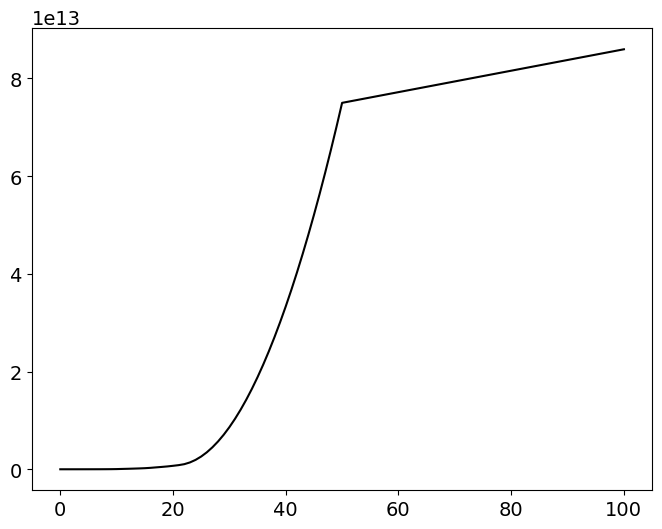

In [93]:
plt.plot(sim1.scenario['r_PERC'].dataOut_m['Installed_Capacity_[W]'])

In [94]:
#sim1.scenario['PV_ICE'].dataOut_m['irradiance_stc'].head(2)
sim1.scenario.keys()

dict_keys(['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'h_50PERC', 'h_RecycledPERC', 'h_Perovskite', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA'])

# RESULTS: Effective Capacity and Replacements

In [96]:
sim1.scenario['h_RecycledPERC'].dataOut_m['WeibullParams'].tail(4)

97     {'alpha': 16.199948952041623, 'beta': 39.89240...
98     {'alpha': 16.199948952041623, 'beta': 39.89240...
99     {'alpha': 16.199948952041623, 'beta': 39.89240...
100    {'alpha': 16.199948952041623, 'beta': 39.89240...
Name: WeibullParams, dtype: object

(0.0, 90.26425956655)

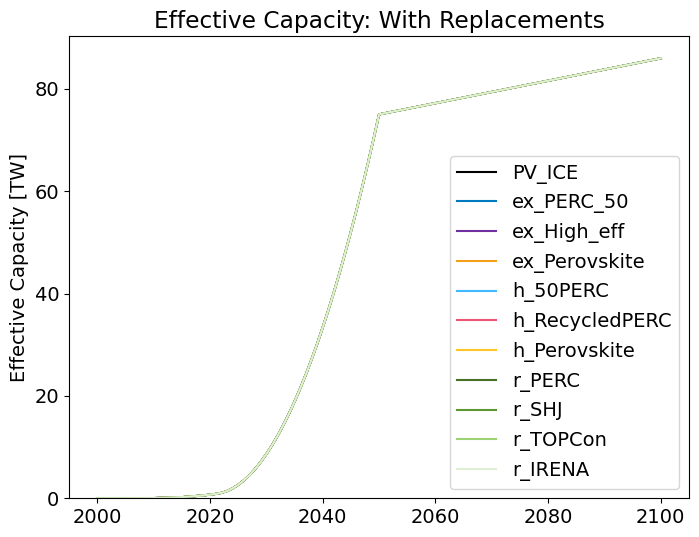

In [97]:
effective_capacity = cc_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: With Replacements')
plt.ylim(0,)

(0.0, 329.8185753278499)

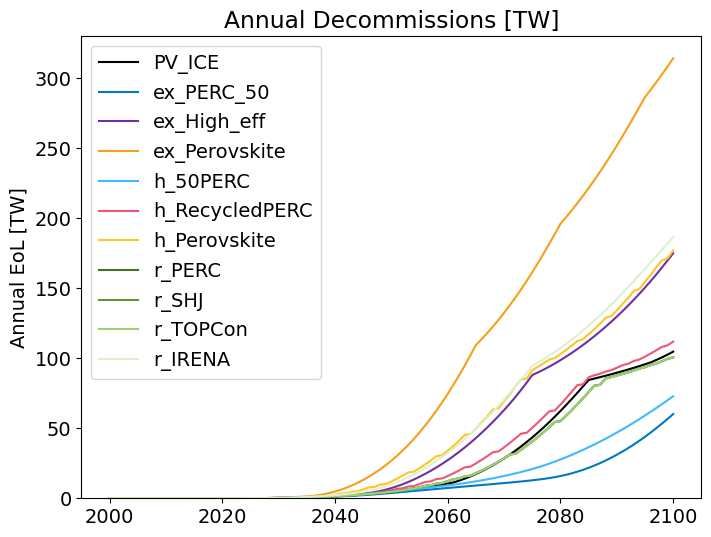

In [98]:
annual_EoL = cc_yearly.filter(like='DecommisionedCapacity')
plt.plot(annual_EoL/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual EoL [TW]')
plt.title('Annual Decommissions [TW]')
plt.ylim(0,)

(0.0, 8.54311618686425)

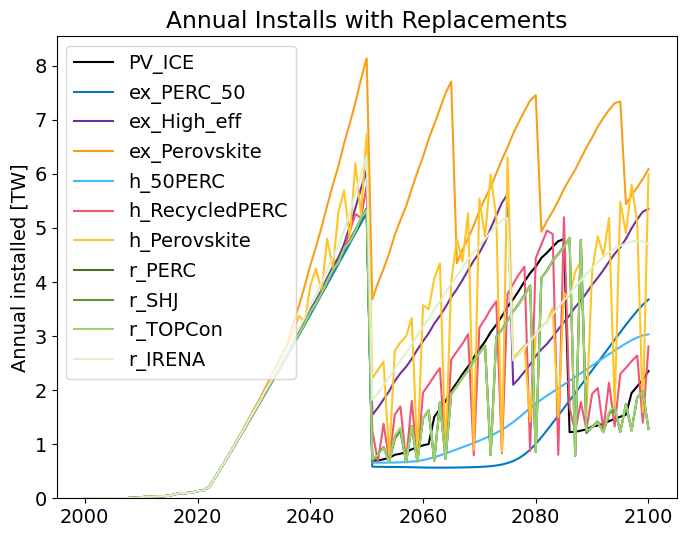

In [99]:
annual_installs = cc_yearly.filter(like='newInstalled')
plt.plot(annual_installs/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')
plt.ylim(0,)

(0.0, 420.0828348943998)

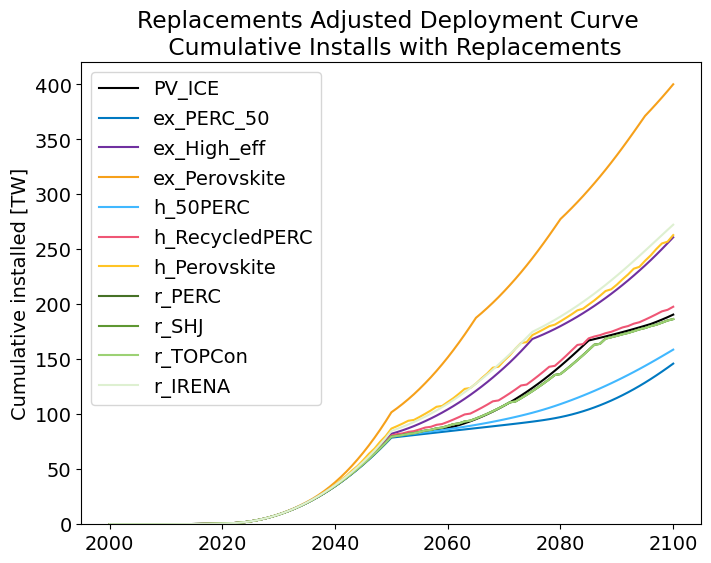

In [100]:
cumu_installs_annually = cc_cumu.filter(like='newInstalled')
plt.plot(cumu_installs_annually/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Cumulative installed [TW]')
plt.title('Replacements Adjusted Deployment Curve \n Cumulative Installs with Replacements')
plt.ylim(0,)

(0.0, 410.0)

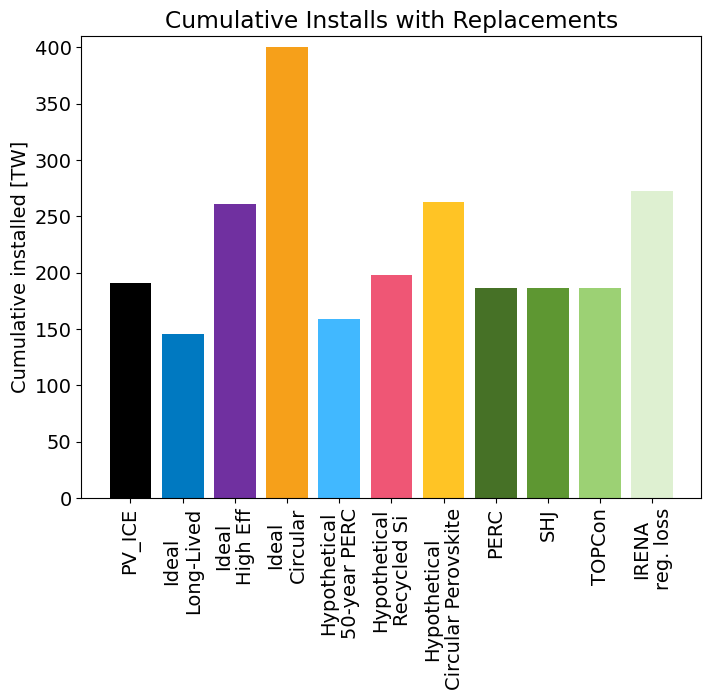

In [101]:
cumu_installs = cc_cumu.filter(like='newInstalled')
plt.bar(scennames_labels, cumu_installs.loc[2100]/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.xticks(rotation=90)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')
plt.ylim(0,410)

In [102]:
cumulative_nameplate_installs = global_projection.loc[2100,'World_cum'] #MW
print('The nameplate installations for energy transition and through 2100 are '+str(cumulative_nameplate_installs/1e6)+' TW.')

The nameplate installations for energy transition and through 2100 are 85.966 TW.


In [103]:
global_projection['World_annual_[MWdc]'].sum()

85966000.0

(0.0, 410.0)

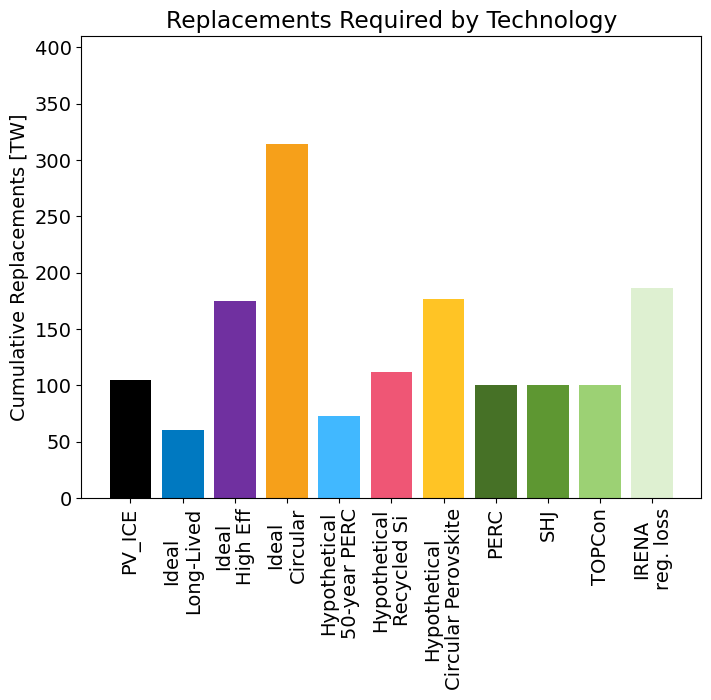

In [104]:
Additional_installs = cumu_installs.loc[2100]-global_projection.loc[2100,'World_cum']
plt.bar(scennames_labels, Additional_installs/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative Replacements [TW]')
plt.title('Replacements Required by Technology')
plt.xticks(rotation=90)
plt.ylim(0,410)

# RESULTS: Virgin Material Demands

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'Ideal\nLong-Lived'),
  Text(2.0, 0, 'Ideal\nHigh Eff'),
  Text(3.0, 0, 'Ideal\nCircular'),
  Text(4.0, 0, 'Hypothetical\n50-year PERC'),
  Text(5.0, 0, 'Hypothetical\nRecycled Si'),
  Text(6.0, 0, 'Hypothetical\nCircular Perovskite'),
  Text(7.0, 0, 'PERC'),
  Text(8.0, 0, 'SHJ'),
  Text(9.0, 0, 'TOPCon'),
  Text(10.0, 0, 'IRENA\nreg. loss')])

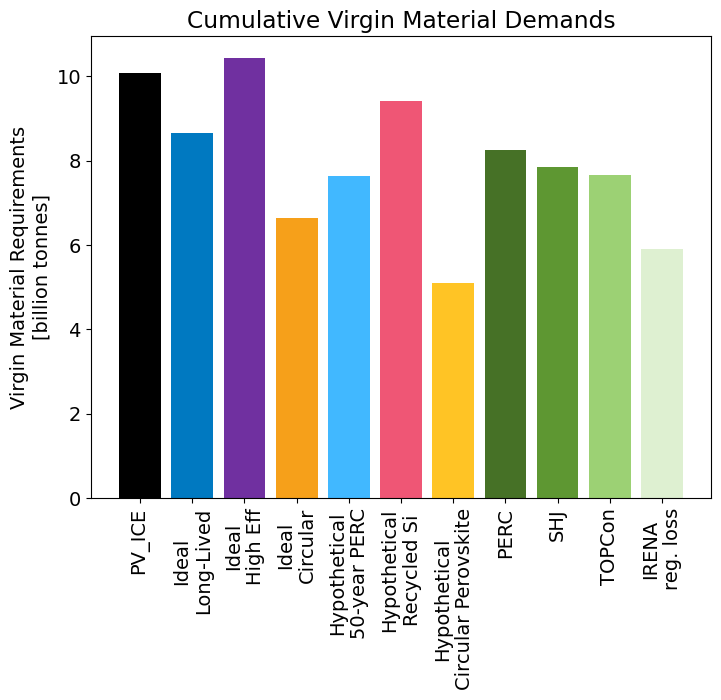

In [105]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.bar(scennames_labels, cumu_virgin_module.loc[2100]/1e9, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Virgin Material Demands')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.xticks(rotation=90)

Text(0, 0.5, 'Million Metric tonnes')

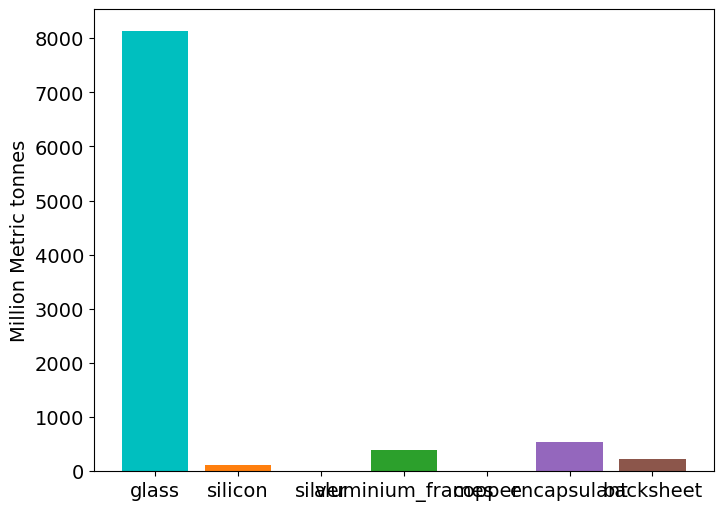

In [106]:
recycledperc_virginstock = cc_cumu.filter(like='VirginStock').filter(like='Recycled')
recycledperc_virginstock.drop('VirginStock_Module_sim1_h_RecycledPERC_[Tonnes]',axis=1, inplace=True)
plt.bar(recycledperc_virginstock.columns, recycledperc_virginstock.loc[2100]/1e6, tick_label = MATERIALS, color=colormats)
plt.ylabel('Million Metric tonnes')

(0.0, 10.952169961082657)

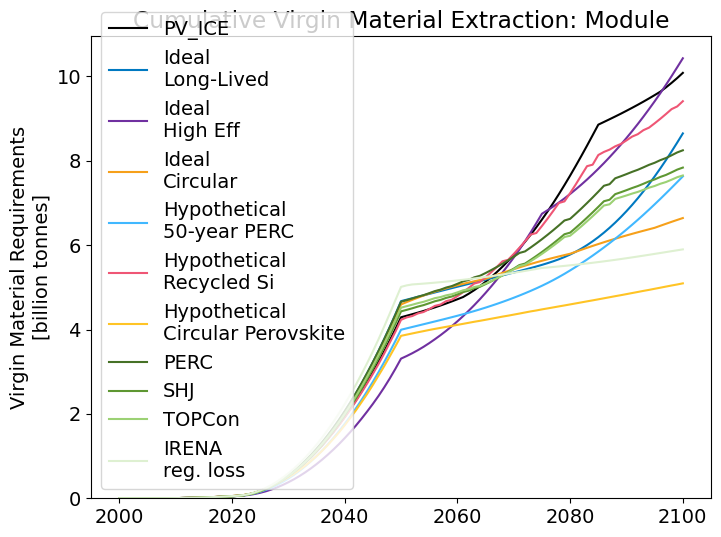

In [107]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.plot(cumu_virgin_module/1e9)
plt.legend(scennames_labels)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.ylim(0,)

(0.0, 332.92224345638414)

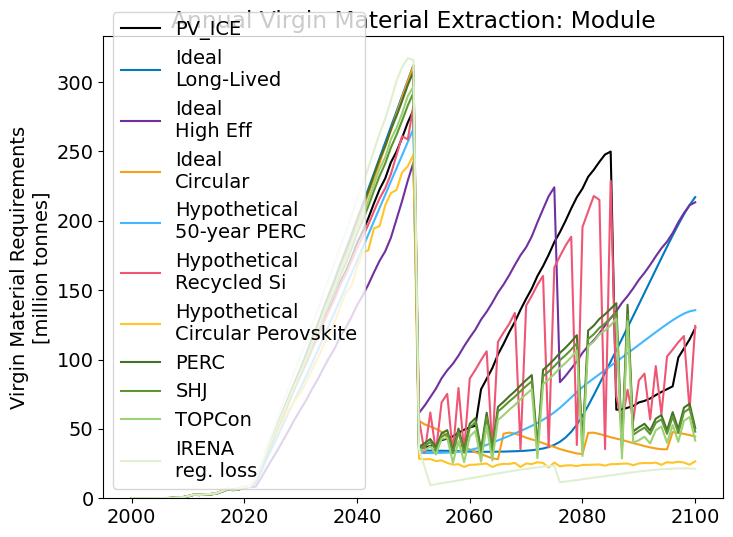

In [108]:
annual_virgin_module = cc_yearly.filter(like='VirginStock_Module')
plt.plot(annual_virgin_module/1e6)
plt.legend(scennames_labels)
plt.title('Annual Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[million tonnes]')
plt.ylim(0,)

In [109]:
#print out masses for stacked bar charts
#mass_cumu = cc_cumu.loc[[2100]].filter(like='PV_ICE_[Tonnes]')
mass_cumu_virgin = cc_cumu.filter(like='VirginStock').loc[2100]
mass_cumu_wasteall = cc_cumu.filter(like='WasteAll').loc[2100]
mass_cumu = pd.concat([mass_cumu_virgin,mass_cumu_wasteall])
mass_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_2100results.csv'))

In [110]:
cc_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_results.csv'))

# RESULTS: Lifecycle Wastes

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'Ideal\nLong-Lived'),
  Text(2.0, 0, 'Ideal\nHigh Eff'),
  Text(3.0, 0, 'Ideal\nCircular'),
  Text(4.0, 0, 'Hypothetical\n50-year PERC'),
  Text(5.0, 0, 'Hypothetical\nRecycled Si'),
  Text(6.0, 0, 'Hypothetical\nCircular Perovskite'),
  Text(7.0, 0, 'PERC'),
  Text(8.0, 0, 'SHJ'),
  Text(9.0, 0, 'TOPCon'),
  Text(10.0, 0, 'IRENA\nreg. loss')])

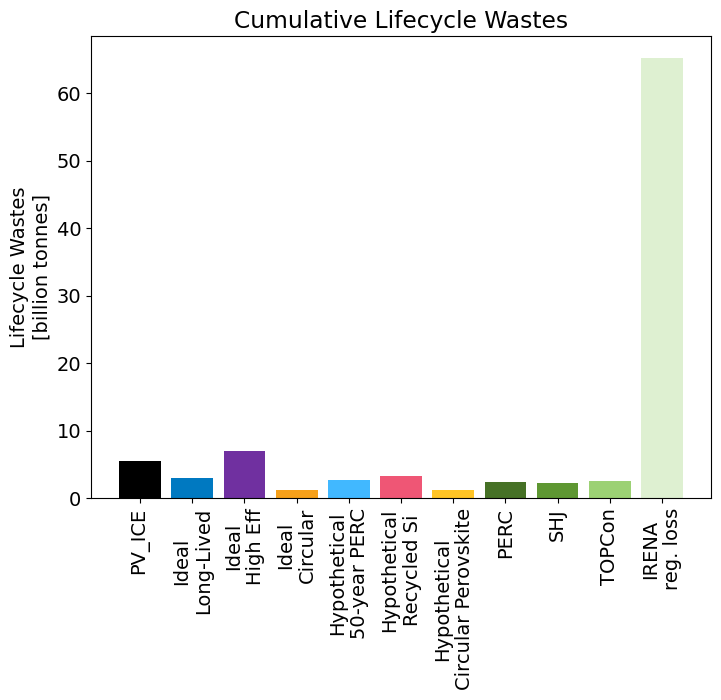

In [111]:
cumu_lifecycle_wastes = cc_cumu.filter(like='WasteAll_Module')

plt.bar(scennames_labels, cumu_lifecycle_wastes.loc[2100]/1e9, 
        tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Lifecycle Wastes')
plt.ylabel('Lifecycle Wastes\n[billion tonnes]')
plt.xticks(rotation=90)

(0.0, 2953.9777196793398)

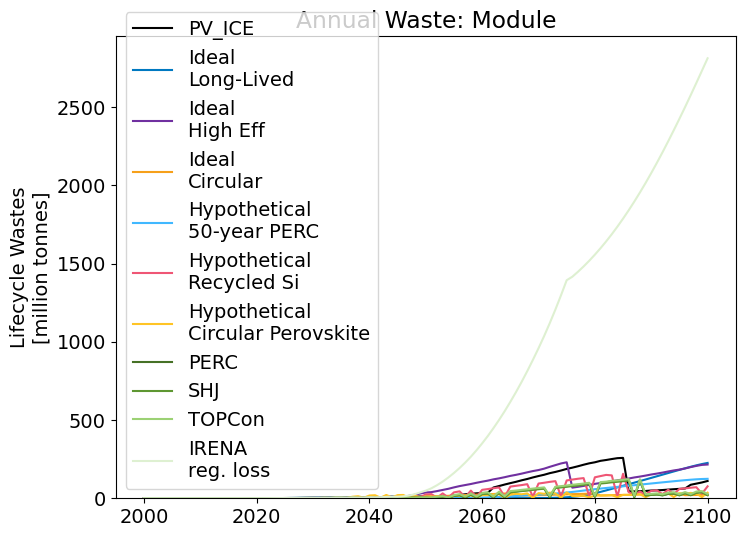

In [112]:
annual_waste_module = cc_yearly.filter(like='WasteAll_Module')
plt.plot(annual_waste_module/1e6)
plt.legend(scennames_labels)
plt.title('Annual Waste: Module')
plt.ylabel('Lifecycle Wastes\n[million tonnes]')
plt.ylim(0,)

In [113]:
sim1.scenario['r_IRENA'].dataOut_m.loc[45:,]

Area  Area_for_EOL_pathsG  Cumulative_Active_Area  EOL_BS_Year0  \
45   2.161127e+10         0.000000e+00            2.647719e+11           0.0   
46   2.282392e+10         1.513471e+08            2.861661e+11           0.0   
47   2.426058e+10         0.000000e+00            3.082348e+11           0.0   
48   2.573972e+10         0.000000e+00            3.309553e+11           0.0   
49   2.735478e+10         0.000000e+00            3.542727e+11           0.0   
50   2.875429e+10         0.000000e+00            3.783066e+11           0.0   
51   8.277558e+09         0.000000e+00            3.808927e+11           0.0   
52   8.834297e+09         0.000000e+00            3.833459e+11           0.0   
53   9.508524e+09         0.000000e+00            3.856261e+11           0.0   
54   1.019022e+10         0.000000e+00            3.877432e+11           0.0   
55   1.090978e+10         0.000000e+00            3.896927e+11           0.0   
56   1.157216e+10         0.000000e+00            3.914786e+11           0.0   
57   1.225090e+10         0.000000e+00            3.931001e+11           0.0   
58   1.292830e+10         0.000000e+00            3.945617e+11           0.0   
59   1.370120e+10         0.000000e+00            3.958380e+11           0.0   
60   1.441552e+10         0.000000e+00            3.969540e+11           0.0   
61   1.508835e+10         0.000000e+00            3.979283e+11           0.0   
62   1.587704e+10         0.000000e+00            3.987287e+11           0.0   
63   1.654507e+10         0.000000e+00            3.993973e+11           0.0   
64   1.727432e+10         0.000000e+00            3.999183e+11           0.0   
65   1.804612e+10         0.000000e+00            4.002818e+11           0.0   
66   1.869317e+10         0.000000e+00            4.005271e+11           0.0   
67   1.937908e+10         0.000000e+00            4.006440e+11           0.0   
68   2.008369e+10         0.000000e+00            4.006280e+11           0.0   
69   2.071387e+10         0.000000e+00            4.005012e+11           0.0   
70   2.119130e+10         0.000000e+00            4.003067e+11           0.0   
71   2.177890e+10         0.000000e+00            4.000148e+11           0.0   
72   2.239079e+10         0.000000e+00            3.996221e+11           0.0   
73   2.290722e+10         0.000000e+00            3.991588e+11           0.0   
74   2.336760e+10         0.000000e+00            3.986468e+11           0.0   
75   2.356761e+10         0.000000e+00            3.981623e+11           0.0   
76   1.158800e+10         0.000000e+00            4.007343e+11           0.0   
77   1.207486e+10         0.000000e+00            4.032014e+11           0.0   
78   1.263233e+10         0.000000e+00            4.055457e+11           0.0   
79   1.319500e+10         0.000000e+00            4.077659e+11           0.0   
80   1.377923e+10         0.000000e+00            4.098565e+11           0.0   
81   1.433096e+10         0.000000e+00            4.118257e+11           0.0   
82   1.489287e+10         0.000000e+00            4.136708e+11           0.0   
83   1.545399e+10         0.000000e+00            4.153916e+11           0.0   
84   1.606664e+10         0.000000e+00            4.169747e+11           0.0   
85   1.664041e+10         0.000000e+00            4.184295e+11           0.0   
86   1.718538e+10         0.000000e+00            4.197623e+11           0.0   
87   1.778734e+10         0.000000e+00            4.209577e+11           0.0   
88   1.830806e+10         0.000000e+00            4.220351e+11           0.0   
89   1.884899e+10         0.000000e+00            4.229880e+11           0.0   
90   1.939256e+10         0.000000e+00            4.238139e+11           0.0   
91   1.983963e+10         0.000000e+00            4.245355e+11           0.0   
92   2.027973e+10         0.000000e+00            4.251528e+11           0.0   
93   2.069356e+10         0.000000e+00            4.256707e+11           0.0   
94   2.102219

# RESULTS: Energy

In [ ]:
sim1.scenario['r_SHJ'].dataOut_e

## Energy Generation
Because of different bifi factors, they do NOT produce the same energy

In [ ]:
#energyGen = allenergy.filter(like='e_out_annual')
plt.plot(energyGen/1e12)
plt.legend(scennames_labels)
plt.title('Annual Energy Generation')
plt.ylabel('Energy Generation [TWh]')
plt.ylim(0,)

## Net Energy

In [ ]:
e_annual_sumDemands = energy_demands.filter(like='demand_total')

In [ ]:
plt.plot(e_annual_sumDemands/1e12)
plt.legend(scennames_labels)
plt.title('Annual Lifecycle Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')
plt.ylim(0,)

In [ ]:
e_annual_sumDemands_cumu = e_annual_sumDemands.cumsum()

In [ ]:
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulative Lifecycle Energy Demands')
plt.ylabel('Cumulative Energy Demands\n[TWh]')
plt.xticks(rotation=90)

In [ ]:
e_fuels = energy_demands.filter(like='_fuel')
e_energydemands = energy_demands.loc[:,~energy_demands.columns.isin(e_fuels.columns)]
e_mfging_bymat = pd.DataFrame()
for scen in sim1.scenario.keys():
    e_energy_mfg_scen = e_energydemands.filter(like=scen).filter(like='_MFG_')
    e_energy_mod_mfg_scen = energy_demands.filter(like=scen).filter(like='mod_MFG')
    e_mfging_bymat = pd.concat([e_mfging_bymat,e_energy_mfg_scen,e_energy_mod_mfg_scen], axis=1)

In [ ]:
cum_e_mfging_bymat = e_mfging_bymat.cumsum().loc[2100]
cum_e_mfging_bymat

In [ ]:
#run 2x rn??
#energy demands by material mfging
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)

#Materials
cume_mfg_glass = cum_e_mfging_bymat.filter(like='glass')
cume_mfg_silicon = cum_e_mfging_bymat.filter(like='silicon')
cume_mfg_silver = cum_e_mfging_bymat.filter(like='silver')
cume_mfg_aluminium_frames = cum_e_mfging_bymat.filter(like='aluminium_frames')
cume_mfg_copper = cum_e_mfging_bymat.filter(like='copper')
cume_mfg_encapsulant = cum_e_mfging_bymat.filter(like='encapsulant')
cume_mfg_backsheet = cum_e_mfging_bymat.filter(like='backsheet')
cume_mfg_mod = cum_e_mfging_bymat.filter(like='mod')

bot_ag = cume_mfg_glass.values+cume_mfg_silicon.values
bot_al = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values
bot_cu = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values
bot_encap = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values
bot_back = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values
bot_mod = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values+cume_mfg_backsheet.values

plt.bar(scennames_labels, cume_mfg_glass, color = colormats[0])
plt.bar(scennames_labels, cume_mfg_silicon, bottom = cume_mfg_glass, color=colormats[1])
plt.bar(scennames_labels, cume_mfg_silver, bottom = bot_ag, color=colormats[2])
plt.bar(scennames_labels, cume_mfg_aluminium_frames, bottom = bot_al, color=colormats[3])
plt.bar(scennames_labels, cume_mfg_copper, bottom = bot_cu , color=colormats[4])
plt.bar(scennames_labels, cume_mfg_encapsulant, bottom = bot_encap ,color=colormats[5])
plt.bar(scennames_labels, cume_mfg_backsheet, bottom = bot_back, color=colormats[6])
plt.bar(scennames_labels, cume_mfg_mod, bottom = bot_back, color='white')

plt.xticks(rotation=90)

plt.legend(MATERIALS)

In [ ]:
energyGen_cumu = energyGen.cumsum()
energyGen_cumu.columns = e_annual_sumDemands_cumu.columns = scennames_labels
netEnergy_cumu = energyGen_cumu.loc[[2100]] - e_annual_sumDemands_cumu.loc[[2100]]

In [ ]:
e_annual_sumDemands_cumu.loc[[2100]]

In [ ]:
netEnergy_cumu

In [ ]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy [TWh]')
#plt.ylim(4e6,5.5e6)
plt.xticks(rotation=90)

In [ ]:
netEnergy_relative = netEnergy_cumu - netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_relative
plt.bar(netEnergy_relative.columns, netEnergy_relative.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulatively Net Energy Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy [TWh]')
plt.xticks(rotation=90)

In [ ]:
netEnergy_cumu_norm = netEnergy_cumu/netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_cumu_norm_waterfall = netEnergy_cumu_norm-1
netEnergy_cumu_norm


In [ ]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu_norm_waterfall.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy')
#plt.ylim(-0.026,0.005)
plt.plot(0.0, lw=2)
plt.xticks(rotation=90)

In [ ]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy\n[TWh]')
plt.xticks(rotation=90)

In [ ]:
energyGen.columns = e_annual_sumDemands.columns = scennames_labels
annual_net_energy = energyGen - e_annual_sumDemands

In [ ]:
plt.plot(annual_net_energy/1e12)
plt.legend(scennames_labels)
plt.title('Annual Net Energy')
plt.ylabel('Net Energy (Eout - Ein)\n[TWh]')
plt.ylim(0,)
plt.xlim(2000,2100)

## System Level EROI
This may not be an accurate use of EROI, but I want to see what will happen

In [ ]:
eroi_sys_cumu = energyGen_cumu/e_annual_sumDemands_cumu

In [ ]:
plt.bar(eroi_sys_cumu.columns, eroi_sys_cumu.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI of all Deployments')
plt.ylabel('Unitless')
plt.xticks(rotation=90)

# CE-TE Metric
Net Energy over Linear mass flow

In [ ]:
#cumulatively
netEnergy_cumu.columns = cumu_virgin_module.columns = cumu_lifecycle_wastes.columns = scennames_labels

CEETmetric = (netEnergy_cumu.loc[2100]/1e6)/ (cumu_virgin_module.loc[2100]+ cumu_lifecycle_wastes.loc[2100])

In [ ]:
plt.bar(CEETmetric.index, CEETmetric, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('CETE Metric')
plt.ylabel('Net Energy / Linear Mass \n[MWh/tonne]')

# EROI
Create single installation simulation to evaluate EROI of modules. Do one round of 2022 modules and one of 2050 modules.
## EROI 2022

In [ ]:
single_deploy_2022 = pd.DataFrame(index=idx_temp, columns=['MW'], dtype=float)
single_deploy_2022['MW'] = 0.0
single_deploy_2022.loc[2022] = 100.0 #install a single 100 MW system

In [ ]:
sim2 = PV_ICE.Simulation(name='sim2', path=testfolder)
for scen in scennames:
    sim2.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim2.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [ ]:
#use the settings from the first simulation to create the identical settings for sim2
for scen in scennames:
    sim2.scenario[scen].dataIn_m = sim1.scenario[scen].dataIn_m
    sim2.scenario[scen].dataIn_e = sim1.scenario[scen].dataIn_e
    for mat in MATERIALS:
        sim2.scenario[scen].material[mat].matdataIn_m = sim1.scenario[scen].material[mat].matdataIn_m
        sim2.scenario[scen].material[mat].matdataIn_e = sim1.scenario[scen].material[mat].matdataIn_e
        

In [ ]:
sim2.scenario['Perovskite'].material['glass'].matdataIn_m

In [ ]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim2.trim_Years(startYear=2000, endYear=2100)

In [ ]:
#deployment projection for all scenarios
sim2.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', value= single_deploy_2022['MW'], start_year=2000)


In [ ]:
sim2.scenario['Perovskite'].dataIn_m.loc[19:25]

In [ ]:
for scen in scennames:
    sim2.calculateFlows(scenarios=[scen],bifacialityfactors=bifiPathDict[scen])

In [ ]:
sim2_yearly, sim2_cumulative = sim2.aggregateResults()

In [ ]:
allenergy2, energyGen2, energy_demands2 = sim2.aggregateEnergyResults()

In [ ]:
allenergy2_cumu = allenergy2.cumsum()
energyGen2_cumu = energyGen2.cumsum()
energy_demands2_cumu = energy_demands2.cumsum()

In [ ]:
energy_demands2_cumu_total = energy_demands2_cumu.filter(like='demand_total')
#energy_demands2_cumu_total

In [ ]:
plt.bar(energy_demands2_cumu_total.columns, energy_demands2_cumu_total.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Energy Demands Cumulative')
plt.ylabel('Energy Demands [Wh]')

In [ ]:
energyGen2_cumu.columns=energy_demands2_cumu_total.columns=scennames_labels
eroi_2022 = energyGen2_cumu.iloc[100]/energy_demands2_cumu_total.iloc[100]
eroi_2022

In [ ]:
plt.bar(eroi_2022.index, eroi_2022, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI')
plt.ylabel('Arb.')

In [ ]:
plt.plot(energyGen2/1e9)
plt.legend(scennames_labels)
plt.title('Energy Generation - Single 2022 System')
plt.ylabel('[GWh]')

## EROI of 2050 module

In [ ]:

single_deploy_2050 = pd.DataFrame(index=idx_temp, columns=['MW'], dtype=float)
single_deploy_2050['MW'] = 0.0
single_deploy_2050.loc[2050] = 100.0 #install a single 100 MW system

In [ ]:
sim3 = PV_ICE.Simulation(name='sim3', path=testfolder)
for scen in scennames:
    sim3.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim3.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [ ]:
#use the settings from the first simulation to create the identical settings for sim2
for scen in scennames:
    sim3.scenario[scen].dataIn_m = sim1.scenario[scen].dataIn_m
    sim3.scenario[scen].dataIn_e = sim1.scenario[scen].dataIn_e
    for mat in MATERIALS:
        sim3.scenario[scen].material[mat].matdataIn_m = sim1.scenario[scen].material[mat].matdataIn_m
        sim3.scenario[scen].material[mat].matdataIn_e = sim1.scenario[scen].material[mat].matdataIn_e
        

In [ ]:
sim3.scenario['Perovskite'].material['glass'].matdataIn_m

In [ ]:
#deployment projection for all scenarios
sim3.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', value= single_deploy_2050['MW'], start_year=2000)


In [ ]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim3.trim_Years(startYear=2000, endYear=2150)

In [ ]:
sim3.scenario['Perovskite'].dataIn_e.tail(4)#loc[49:55]

In [ ]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
#need to adjust for length to 2150
idx_temp_2150 = pd.RangeIndex(start=2000,stop=2151,step=1) #create the index
df_temp_2150 = pd.DataFrame(index=idx_temp_2150, columns=['bifi'], dtype=float)
bifiPathDict_2150={}

for f in bifiFactors.keys(): #loop over module types
    bifi_2150 = df_temp_2150.copy() #copy of df
    bifi_2150['bifi'] = bifiFactors[f] #assign column
    bifipath_2150 = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi_2150.to_csv(path_or_buf=bifipath_2150, index_label='year') #create file
    bifiPathDict_2150[str(f)] = bifipath_2150
    #append bifi path to dict? or list?


In [ ]:
for scen in scennames:
    sim3.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict_2150[scen])

In [ ]:
sim3_yearly, sim3_cumulative = sim3.aggregateResults()

In [ ]:
allenergy3, energyGen3, energy_demands3 = sim3.aggregateEnergyResults()

In [ ]:
allenergy3_cumu = allenergy3.cumsum()
energyGen3_cumu = energyGen3.cumsum()
energy_demands3_cumu = energy_demands3.cumsum()

In [ ]:
energy_demands3_cumu_total = energy_demands3_cumu.filter(like='demand_total')
#energy_demands3_cumu_total

In [ ]:
plt.bar(energy_demands3_cumu_total.columns, energy_demands3_cumu_total.loc[2150], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Energy Demands Cumulative 2050 System')
plt.ylabel('Energy Demands [Wh]')

In [ ]:
energyGen3_cumu.columns = energy_demands3_cumu_total.columns = scennames_labels
eroi_2050 = energyGen3_cumu.loc[2150]/energy_demands3_cumu_total.loc[2150]
eroi_2050

In [ ]:
plt.bar(eroi_2050.index, eroi_2050, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI of a 100 MW deployment in 2050')
plt.ylabel('Arbitrary units')

In [ ]:
plt.plot(energyGen3/1e9)
plt.legend(scennames_labels)
plt.title('Energy Generation - Single 2050 System')
plt.ylabel('[GWh]')

# To Do
- energy requirements on a per MW installed for a single install, what is MFG
- Y axis = normalized net energy of perovskites, x axis = remanufacturing energy variation, maybe add recycling Just change one variable 

- lowest energy = remfg
- mid energy = recycle
- high energy = virgin mfg